<a href="https://colab.research.google.com/github/jiyanshud22/Affective-Computing/blob/main/zoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zoning

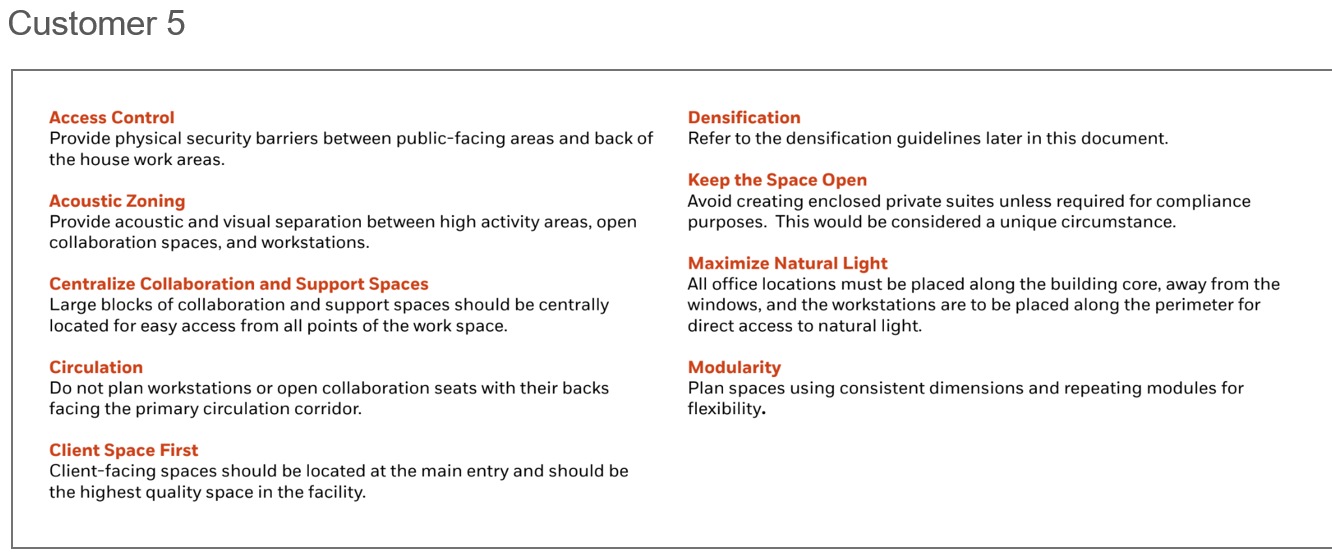

# Zones:

W: WORKSTATIONS

E: ENCLOSED OFFICES

C: CAFE/PANTRY SUPPORT

L: COLLABORATIVE SEATING

M: MEETING SPACE/PHONE ROOM

S: SPECIALTY

R: RECEPTION/CLIENT-FACING COLLABORATIVE SPACE

# k ∈ {W, E, C, L, M, S, R}

#Decision Variables
 x ijk  be a binary variable :




  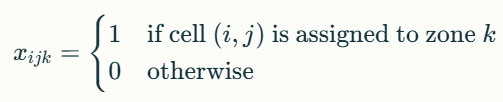

# Defining other Variables
Area Density: d

Capped task area:  **A task** = min
⁡
(
1278.46
,
d
×
∑
seats
)


Max seating capacity: **n seats**=⌊A task / d⌋


Side of Square

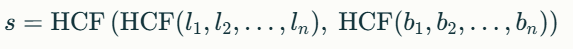

side length of square grid cells is HCF  to ensure all zones fit perfectly into the grid.

After that we get rows and column of grid:

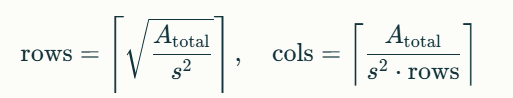

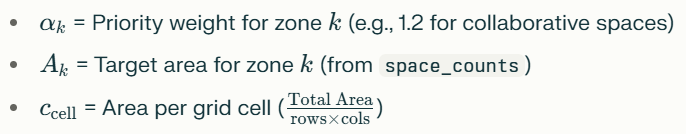


#Objective Function for Zoning


S ijk   is the suitability score of zone
k in cell
(i,j)

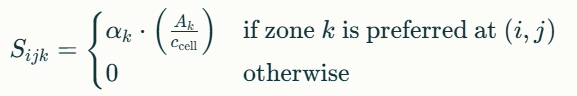

#Maximize total suitability

# 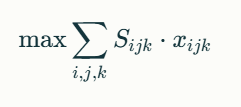

# Constarints

#Area Budget Constraint:
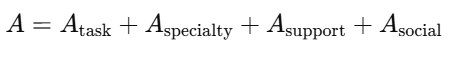

#(Adjacency Rules) collaborative zones near core

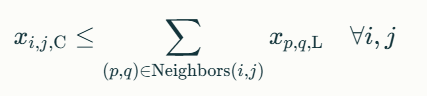

# Periphery Constraint (Workstations zones at edges)


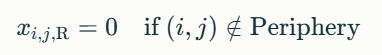

# We apply big block constraint on all zones as we do not want seperated seat or head counts for each zone

# Area for Zone k (e.g., workstations)


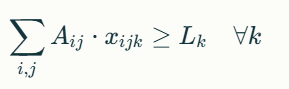

A k  is the target area for zone
k


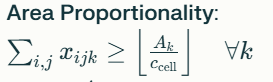

Enter the floor to plan (e.g., Ground Floor, Level 2) [Level 2]: 
Enter Total Usable Area (SQM) [2363]: 
Enter Anchor Resident % [11.71]: 
Enter Collaborator % [0.6]: 
Enter Density (SQM per seat) [12.94]: 
Individual Zone Work Desks (no partition) [46]: 
Individual Zone Phone Booths (Single) [3]: 
Individual Zone Phone Booths (Double) [3]: 
Individual Zone Focus Rooms (1p) [5]: 
Individual Zone Focus Rooms (2-3p) [4]: 
Individual Zone Touchdown n Seats [46]: 
Interactive Zone Work Desks (with partitions) [36]: 
Interactive Zone Phone Booths (Single) [3]: 
Interactive Zone Phone Booths (Double) [3]: 
Interactive Zone Focus Rooms (1p) [5]: 
Interactive Zone Focus Rooms (2-3p) [4]: 
Interactive Zone Touchdown n Seats [18]: 
Enter Specialty area (SQM) [250]: 
Enter Support area (SQM) [195.3]: 
Enter Social area (SQM) [91.32]: 


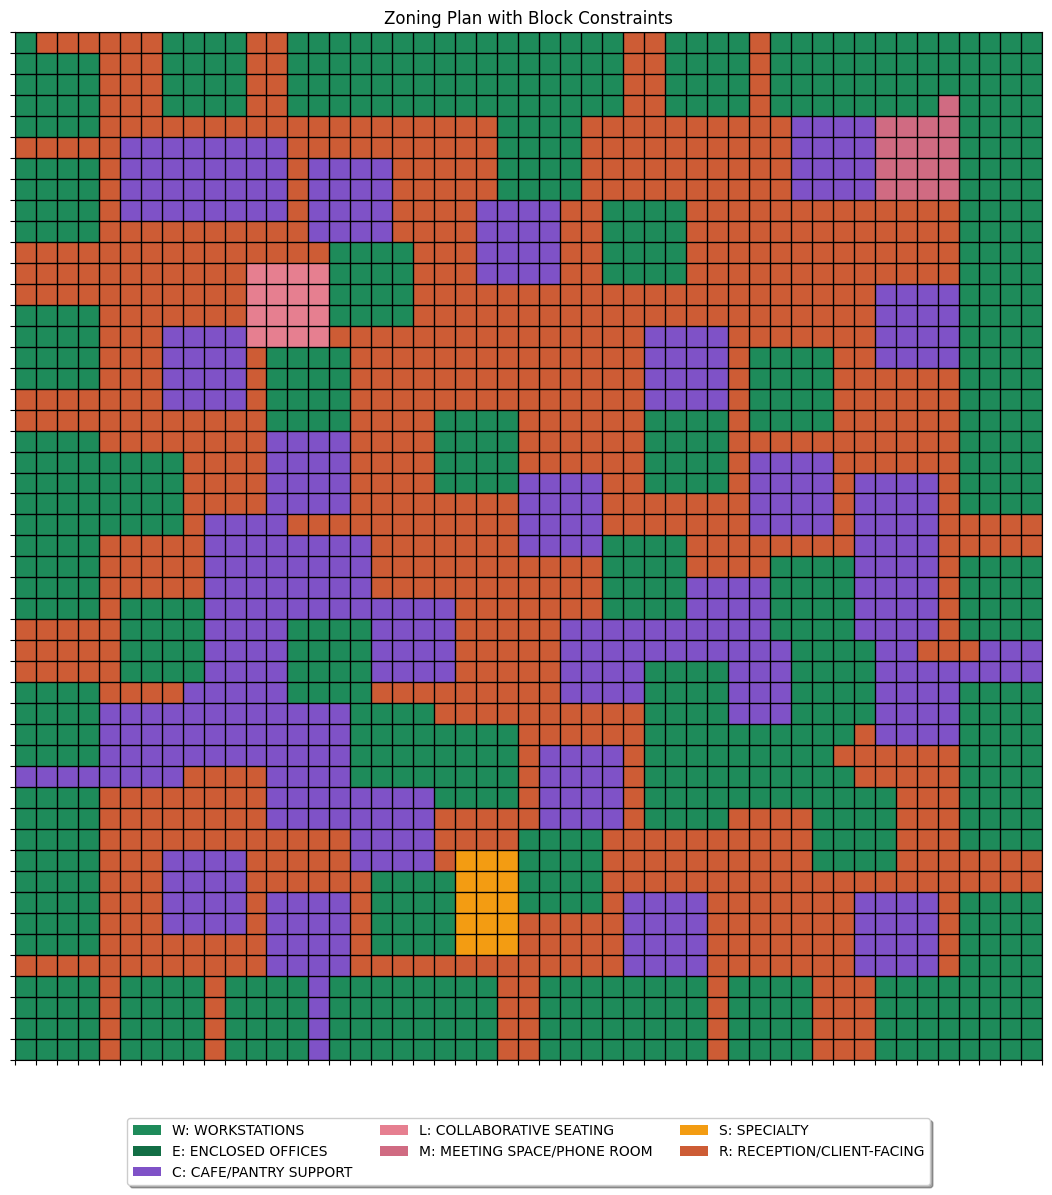

In [22]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict
import logging
logging.getLogger().setLevel(logging.ERROR)


# Sanofi H2O building data (default values)
sanofi_data = {
    "Ground Floor": {"area_sqm": 1595, "anchor_pct": 9.00, "collaborator_pct": 0.41, "density": 16.17},
    "Level 1": {"area_sqm": 1181, "anchor_pct": 5.85, "collaborator_pct": 0.30, "density": 30.37},
    "Level 2": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 3": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 4": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 5": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 6": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 7": {"area_sqm": 2327, "anchor_pct": 11.53, "collaborator_pct": 0.59, "density": 23.59},
    "Level 8": {"area_sqm": 2281, "anchor_pct": 11.30, "collaborator_pct": 0.58, "density": 23.13}
}

# Default seat counts for Typical TF
typical_tf_seats = {
    "Individual Zone Work Desks (no partition)": 46,
    "Individual Zone Phone Booths (Single)": 3,
    "Individual Zone Phone Booths (Double)": 3,
    "Individual Zone Focus Rooms (1p)": 5,
    "Individual Zone Focus Rooms (2-3p)": 4,
    "Individual Zone Touchdown n Seats": 46,
    "Interactive Zone Work Desks (with partitions)": 36,
    "Interactive Zone Phone Booths (Single)": 3,
    "Interactive Zone Phone Booths (Double)": 3,
    "Interactive Zone Focus Rooms (1p)": 5,
    "Interactive Zone Focus Rooms (2-3p)": 4,
    "Interactive Zone Touchdown n Seats": 18
}

def calculate_hcf(a, b):
    while b:
        a, b = b, a % b
    return a

def calculate_grid_dimensions(total_area, zone_areas):
    lengths = [int(total_area * 0.4), int(total_area * 0.2), int(total_area * 0.1), int(total_area * 0.1)]
    hcf = lengths[0]
    for i in range(1, len(lengths)):
        hcf = calculate_hcf(hcf, lengths[i])
    base = hcf
    rows = cols = int(math.sqrt(total_area / base))
    while rows * cols * base < total_area:
        if rows <= cols:
            rows += 1
        else:
            cols += 1
    return rows, cols

def calculate_area_from_seats(seat_counts, density):
    total_seats = sum(seat_counts.values())
    task_area = total_seats * density
    return task_area, total_seats

def is_valid_block_position(grid, row, col, width, height):
    rows, cols = len(grid), len(grid[0])
    if row + height > rows or col + width > cols:
        return False
    for r in range(row, row + height):
        for c in range(col, col + width):
            if grid[r][c] is not None:
                return False
    return True

def place_rectangular_block(grid, row, col, width, height, zone_type):
    for r in range(row, row + height):
        for c in range(col, col + width):
            grid[r][c] = zone_type
    return width * height

def generate_block_sizes(min_size, max_width, max_height, cells_needed):
    blocks = []
    remaining = cells_needed
    for height in range(max(4, min_size), min_size-1, -1):
        for width in range(max(4, min_size), min_size-1, -1):
            block_size = width * height
            while remaining >= block_size:
                blocks.append((width, height))
                remaining -= block_size
    if remaining > 0:
        width = height = min_size
        while remaining >= width * height:
            blocks.append((width, height))
            remaining -= width * height
        if remaining > 0 and blocks:
            last_width, last_height = blocks[-1]
            if last_width >= last_height:
                extra_cols = math.ceil(remaining / last_height)
                blocks[-1] = (last_width + extra_cols, last_height)
            else:
                extra_rows = math.ceil(remaining / last_width)
                blocks[-1] = (last_width, last_height + extra_rows)
            remaining = 0
    return blocks, remaining

def strict_block_zoning(rows, cols, space_counts):
    grid = [[None for _ in range(cols)] for _ in range(rows)]
    min_block_size = 3

    zone_priority = ['R', 'C', 'L', 'M', 'E', 'S']
    unplaced_cells = defaultdict(int)

    def get_peripheral_positions(width, height):
        positions = []
        for col in range(cols - width + 1):
            positions.append((0, col))  # Top edge
            positions.append((rows - height, col))  # Bottom edge
        for row in range(rows - height + 1):
            positions.append((row, 0))  # Left edge
            positions.append((row, cols - width))  # Right edge
        return positions

    # Place Workstations ('W') on periphery
    if 'W' in space_counts and space_counts['W'] > 0:
        cells_needed = space_counts['W']
        block_sizes, remaining = generate_block_sizes(min_block_size, cols, rows, cells_needed)

        if remaining > 0:
            print(f"Warning: Could not generate proper blocks for all W cells. {remaining} cells unplaced.")
            unplaced_cells['W'] += remaining

        for width, height in block_sizes:
            placed = False
            peripheral_positions = get_peripheral_positions(width, height)
            random.shuffle(peripheral_positions)

            for row, col in peripheral_positions:
                if is_valid_block_position(grid, row, col, width, height):
                    place_rectangular_block(grid, row, col, width, height, 'W')
                    placed = True
                    break

            if not placed:
                max_attempts = 100
                attempts = 0
                while not placed and attempts < max_attempts:
                    row = random.randint(0, rows - height)
                    col = random.randint(0, cols - width)
                    if is_valid_block_position(grid, row, col, width, height):
                        place_rectangular_block(grid, row, col, width, height, 'W')
                        placed = True
                    attempts += 1
                if not placed:
                    print(f"Warning: Could not place a {width}x{height} block for zone W after {max_attempts} attempts.")
                    unplaced_cells['W'] += width * height

    # Place other zones
    for zone in zone_priority:
        if zone not in space_counts or space_counts[zone] <= 0:
            continue
        cells_needed = space_counts[zone]
        block_sizes, remaining = generate_block_sizes(min_block_size, cols, rows, cells_needed)

        if remaining > 0:
            print(f"Warning: Could not generate proper blocks for all {zone} cells. {remaining} cells unplaced.")
            unplaced_cells[zone] += remaining

        for width, height in block_sizes:
            max_attempts = 100
            placed = False
            attempts = 0
            while not placed and attempts < max_attempts:
                row = random.randint(0, rows - height)
                col = random.randint(0, cols - width)
                if is_valid_block_position(grid, row, col, width, height):
                    place_rectangular_block(grid, row, col, width, height, zone)
                    placed = True
                attempts += 1
                if not placed:
                    print(f"Warning: Could not place a {width}x{height} block for zone {zone} after {max_attempts} attempts.")
                    unplaced_cells[zone] += width * height

    # Handle unplaced cells
    if sum(unplaced_cells.values()) > 0:
        print(f"Attempting to place {sum(unplaced_cells.values())} remaining cells by expanding existing blocks...")
        for zone, count in unplaced_cells.items():
            zone_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] == zone]
            for _ in range(count):
                expanded = False
                random.shuffle(zone_cells)
                for r, c in zone_cells:
                    for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                        nr, nc = r + dr, c + dc
                        if (0 <= nr < rows and 0 <= nc < cols and grid[nr][nc] is None):
                            grid[nr][nc] = zone
                            zone_cells.append((nr, nc))
                            expanded = True
                            break
                    if expanded:
                        break

    # Fill empty cells
    empty_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] is None]
    if empty_cells:
        dominant_zone = max(space_counts.items(), key=lambda x: x[1])[0]
        print(f"Filling {len(empty_cells)} remaining empty cells with {dominant_zone}")
        for r, c in empty_cells:
            grid[r][c] = dominant_zone

    return grid

def visualize_zoning_grid(grid, category_names):
    rows, cols = len(grid), len(grid[0])
    color_map = {
        'W': '#1E8B5A',  # Green for workstations
        'E': '#126E45',  # Dark green for enclosed offices
        'C': '#7F52C7',  # Purple for cafe/pantry
        'L': '#E67F90',  # Pink for collaborative seating
        'M': '#D06B82',  # Dark pink for meeting spaces
        'S': '#F39C12',  # Orange for specialty
        'R': '#CD5C35'   # Red/orange for reception
    }
    numeric_grid = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            numeric_grid[r, c] = list(color_map.keys()).index(grid[r][c])
    colors = [color_map[k] for k in color_map.keys()]
    cmap = mcolors.ListedColormap(colors)
    plt.figure(figsize=(12, 12))
    plt.imshow(numeric_grid, cmap=cmap)
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    plt.xticks(np.arange(-.5, cols, 1), [])
    plt.yticks(np.arange(-.5, rows, 1), [])
    patches = [plt.Rectangle((0,0), 1, 1, fc=color_map[code], label=f"{code}: {name}")
               for code, name in category_names.items() if code in color_map]
    plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=3)
    plt.title('Zoning Plan with Block Constraints')
    plt.tight_layout()
    plt.savefig('zoning_plan.png')

def analyze_block_sizes(grid):
    rows, cols = len(grid), len(grid[0])
    visited = [[False for _ in range(cols)] for _ in range(rows)]
    blocks_by_type = defaultdict(list)

    def find_block(r, c, zone_type):
        if (r < 0 or r >= rows or c < 0 or c >= cols or
            visited[r][c] or grid[r][c] != zone_type):
            return []
        visited[r][c] = True
        block = [(r, c)]
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            block.extend(find_block(r + dr, c + dc, zone_type))
        return block

    for r in range(rows):
        for c in range(cols):
            if not visited[r][c]:
                zone_type = grid[r][c]
                block = find_block(r, c, zone_type)
                if block:
                    blocks_by_type[zone_type].append(block)

    print("\nBlock Analysis:")
    for zone_type, blocks in blocks_by_type.items():
        print(f"{zone_type} - {len(blocks)} blocks:")
        for i, block in enumerate(blocks[:10]):  # Limit to 10
            min_r = min(r for r, _ in block)
            max_r = max(r for r, _ in block)
            min_c = min(c for _, c in block)
            max_c = max(c for _, c in block)
            height = max_r - min_r + 1
            width = max_c - min_c + 1
            perfect = len(block) == height * width
            shape = "rectangle" if perfect else "irregular"
            print(f"  Block {i+1}: {len(block)} cells, {width}x{height} bounding box, {shape}")

    single_cells = sum(1 for blocks in blocks_by_type.values() for block in blocks if len(block) == 1)
    print(f"\nSingle cells: {single_cells}")
    return blocks_by_type

def main():
    print("Available floors:", ", ".join(sanofi_data.keys()))
    floor = input("Enter the floor to plan (e.g., Ground Floor, Level 2) [Level 2]: ").strip() or "Level 2"
    if floor not in sanofi_data:
        print("Invalid floor. Using Level 2 as default.")
        floor = "Level 2"

    floor_data = sanofi_data[floor]
    print(f"\nDefault Area Metrics for {floor}:")
    print(f"Total Usable Area: {floor_data['area_sqm']} SQM")
    print(f"Anchor Resident Area: {floor_data['area_sqm'] * (floor_data['anchor_pct'] / 100):.2f} SQM ({floor_data['anchor_pct']}%)")
    print(f"Collaborator Area: {floor_data['area_sqm'] * (floor_data['collaborator_pct'] / 100):.2f} SQM ({floor_data['collaborator_pct']}%)")
    print(f"Density: {floor_data['density']} SQM per seat")

    area_sqm_input = input(f"Enter Total Usable Area (SQM) [{floor_data['area_sqm']}]: ").strip()
    area_sqm = float(area_sqm_input) if area_sqm_input else floor_data['area_sqm']

    anchor_pct_input = input(f"Enter Anchor Resident % [{floor_data['anchor_pct']}]: ").strip()
    anchor_pct = float(anchor_pct_input) if anchor_pct_input else floor_data['anchor_pct']

    collaborator_pct_input = input(f"Enter Collaborator % [{floor_data['collaborator_pct']}]: ").strip()
    collaborator_pct = float(collaborator_pct_input) if collaborator_pct_input else floor_data['collaborator_pct']

    density_input = input(f"Enter Density (SQM per seat) [{floor_data['density']}]: ").strip()
    density = float(density_input) if density_input else floor_data['density']

    print("\nEnter seat counts (default values for Typical TF in brackets):")
    seat_counts = {}
    for desc, default in typical_tf_seats.items():
        count_input = input(f"{desc} [{default}]: ").strip()
        count = int(count_input) if count_input else default
        seat_counts[desc] = count
    task_area, total_seats = calculate_area_from_seats(seat_counts, density)
    print(f"Calculated Task Area: {task_area:.2f} SQM (for {total_seats} seats)")

    areas = {}
    areas["Task"] = min(task_area, 1278.46)
    for cat, default in {"Specialty": 250, "Support": 195.30, "Social": 91.32}.items():
        value_input = input(f"Enter {cat} area (SQM) [{default}]: ").strip()
        value = float(value_input) if value_input else default
        areas[cat] = value
    areas["Total"] = area_sqm

    zone_areas = [areas["Task"], areas["Specialty"], areas["Support"], areas["Social"]]
    rows, cols = calculate_grid_dimensions(area_sqm, zone_areas)
    print(f"Calculated Grid Dimensions: {rows}x{cols}")

    sqm_per_cell = area_sqm / (rows * cols)
    space_counts = {
        "W": round(0.4 * areas["Task"] / sqm_per_cell),
        "E": round(0.1 * areas["Task"] / sqm_per_cell),
        "C": round(0.2 * areas["Total"] / sqm_per_cell),
        "L": round(0.2 * areas["Task"] / sqm_per_cell),
        "M": round(0.1 * areas["Task"] / sqm_per_cell),
        "S": round(areas["Specialty"] / sqm_per_cell),
        "R": round(0.1 * areas["Total"] / sqm_per_cell)
    }
    total_count = sum(space_counts.values())
    if total_count != rows * cols:
        diff = rows * cols - total_count
        space_counts["W"] += diff

    category_names = {
        "W": "WORKSTATIONS",
        "E": "ENCLOSED OFFICES",
        "C": "CAFE/PANTRY SUPPORT",
        "L": "COLLABORATIVE SEATING",
        "M": "MEETING SPACE/PHONE ROOM",
        "S": "SPECIALTY",
        "R": "RECEPTION/CLIENT-FACING"
    }

    grid = strict_block_zoning(rows, cols, space_counts)
    blocks_by_type = analyze_block_sizes(grid)

    print(f"\nZoning Plan for Sanofi H2O {floor} ({rows}x{cols} Grid):")
    for row in grid:
        print(" ".join(f"{cell}" for cell in row))

    print("\nLegend:")

    for code, name in category_names.items():
        print(f"{code}: {name}")

    print(f"\nArea Summary:")
    print(f"Task Area: {areas['Task']:.2f} SQM")
    print(f"Specialty: {areas['Specialty']:.2f} SQM")
    print(f"Support: {areas['Support']:.2f} SQM")
    print(f"Social: {areas['Social']:.2f} SQM")
    print(f"Total: {areas['Total']} SQM")
    print(f"Density: {density} SQM per seat")

    visualize_zoning_grid(grid, category_names)

if __name__ == "__main__":
    main()

# here we see that we dont have the grid dimension, we have total area and percentage of area of zones. so we calculated the side length of square cell, which is HCF of all length and breath of rectangular zones to ensure all zones fit perfectly into the grid.

#we use big block constarint for zones to specify the sizes of the particular zones sites to be rectangular area less than percentage of area of that particular zones and all big blocks should add up to percentage of area of that particular zones

# After that we get rows and column of grid such that total area is covered by the square cells.


# then we apply constraints like W block(workstation) on pheriphery .C, L blocks(cafe and collaboration area)  in the core and zones dont spill out the limit of their percentage area allocated to them .
# Similarly , we can do the zoning for the other constraints

Available floors: Ground Floor, Level 1, Level 2, Level 3, Level 4, Level 5, Level 6, Level 7, Level 8
Enter the floor to plan (e.g., Ground Floor, Level 2): Level 2

Default Area Metrics for Level 2:
Total Usable Area: 2363 SQM
Anchor Resident Area: 276.71 SQM (11.71%)
Collaborator Area: 14.18 SQM (0.6%)
Density: 12.94 SQM per seat
Enter Total Usable Area (SQM) [2363]: 2363
Enter Anchor Resident % [11.71]: 11.71
Enter Collaborator % [0.6]: 0.6
Enter Density (SQM per seat) [12.94]: 12.94

Enter seat counts (default values for Typical TF in brackets):
Individual Zone Work Desks (no partition) [46]: 46
Individual Zone Phone Booths (Single) [3]: 3
Individual Zone Phone Booths (Double) [3]: 3
Individual Zone Focus Rooms (1p) [5]: 5
Individual Zone Focus Rooms (2-3p) [4]: 4
Individual Zone Touchdown n Seats [46]: 46
Interactive Zone Work Desks (with partitions) [36]: 36
Interactive Zone Phone Booths (Single) [3]: 3
Interactive Zone Phone Booths (Double) [3]: 3
Interactive Zone Focus Rooms (

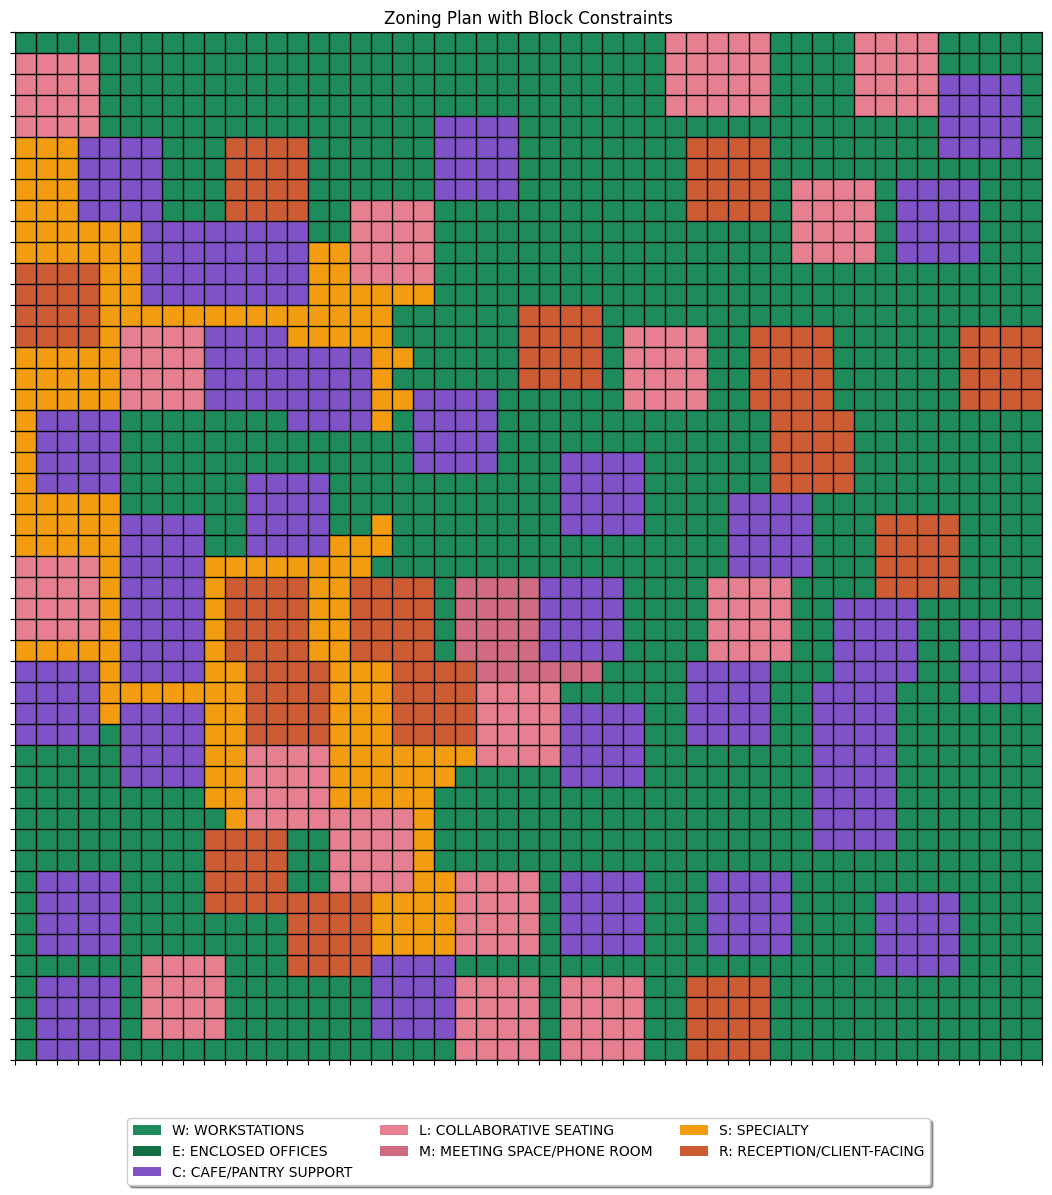

In [ ]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict

# Sanofi H2O building data (default values)
sanofi_data = {
    "Ground Floor": {"area_sqm": 1595, "anchor_pct": 9.00, "collaborator_pct": 0.41, "density": 16.17},
    "Level 1": {"area_sqm": 1181, "anchor_pct": 5.85, "collaborator_pct": 0.30, "density": 30.37},
    "Level 2": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 3": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 4": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 5": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 6": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 7": {"area_sqm": 2327, "anchor_pct": 11.53, "collaborator_pct": 0.59, "density": 23.59},
    "Level 8": {"area_sqm": 2281, "anchor_pct": 11.30, "collaborator_pct": 0.58, "density": 23.13}
}

# Default seat counts for Typical TF
typical_tf_seats = {
    "Individual Zone Work Desks (no partition)": 46,
    "Individual Zone Phone Booths (Single)": 3,
    "Individual Zone Phone Booths (Double)": 3,
    "Individual Zone Focus Rooms (1p)": 5,
    "Individual Zone Focus Rooms (2-3p)": 4,
    "Individual Zone Touchdown n Seats": 46,
    "Interactive Zone Work Desks (with partitions)": 36,
    "Interactive Zone Phone Booths (Single)": 3,
    "Interactive Zone Phone Booths (Double)": 3,
    "Interactive Zone Focus Rooms (1p)": 5,
    "Interactive Zone Focus Rooms (2-3p)": 4,
    "Interactive Zone Touchdown n Seats": 18
}

def calculate_hcf(a, b):
    while b:
        a, b = b, a % b
    return a

def calculate_grid_dimensions(total_area, zone_areas):
    # Approximate lengths based on zone proportions
    lengths = [int(total_area * 0.4), int(total_area * 0.2), int(total_area * 0.1), int(total_area * 0.1)]
    hcf = lengths[0]
    for i in range(1, len(lengths)):
        hcf = calculate_hcf(hcf, lengths[i])
    # Start with a square grid and adjust
    base = hcf
    rows = cols = int(math.sqrt(total_area / base))
    while rows * cols * base < total_area:
        if rows <= cols:
            rows += 1
        else:
            cols += 1
    return rows, cols

def calculate_area_from_seats(seat_counts, density):
    total_seats = sum(seat_counts.values())
    task_area = total_seats * density
    return task_area, total_seats

def is_valid_block_position(grid, row, col, width, height):
    """Check if a block can be placed at the given position"""
    rows, cols = len(grid), len(grid[0])
    if row + height > rows or col + width > cols:
        return False

    for r in range(row, row + height):
        for c in range(col, col + width):
            if grid[r][c] is not None:
                return False
    return True

def place_rectangular_block(grid, row, col, width, height, zone_type):
    """Place a rectangular block of specified dimensions"""
    for r in range(row, row + height):
        for c in range(col, col + width):
            grid[r][c] = zone_type
    return width * height

def generate_block_sizes(min_size, max_width, max_height, cells_needed):
    """Generate a list of block sizes to fit the required number of cells"""
    blocks = []
    remaining = cells_needed

    # Start with larger blocks
    for height in range(max(4, min_size), min_size-1, -1):
        for width in range(max(4, min_size), min_size-1, -1):
            block_size = width * height
            # Add blocks while we have enough remaining cells
            while remaining >= block_size:
                blocks.append((width, height))
                remaining -= block_size

    # If we still have cells to place, add smaller blocks
    if remaining > 0:
        width = height = min_size
        while remaining >= width * height:
            blocks.append((width, height))
            remaining -= width * height

        # If there are still cells, merge them with the last block
        if remaining > 0 and blocks:
            last_width, last_height = blocks[-1]
            # Try to expand the last block
            if last_width >= last_height:
                extra_cols = math.ceil(remaining / last_height)
                blocks[-1] = (last_width + extra_cols, last_height)
            else:
                extra_rows = math.ceil(remaining / last_width)
                blocks[-1] = (last_width, last_height + extra_rows)
            remaining = 0

    return blocks, remaining

def strict_block_zoning(rows, cols, space_counts):
    """Create zoning with strict block constraints - no isolated cells allowed"""
    grid = [[None for _ in range(cols)] for _ in range(rows)]
    min_block_size = 3  # Minimum block size (e.g., 3x3)

    # Define zone priority based on workplace design principles from image
    # Reception (R) and Cafe (C) are placed first as they are central elements
    zone_priority = ['R', 'C', 'L', 'W', 'M', 'E', 'S']

    # Track zones that couldn't be fully placed
    unplaced_cells = defaultdict(int)

    for zone in zone_priority:
        if zone not in space_counts or space_counts[zone] <= 0:
            continue

        cells_needed = space_counts[zone]
        block_sizes, remaining = generate_block_sizes(min_block_size, cols, rows, cells_needed)

        if remaining > 0:
            print(f"Warning: Could not generate proper blocks for all {zone} cells. {remaining} cells unplaced.")
            unplaced_cells[zone] += remaining

        # Try to place each block
        blocks_placed = 0
        cells_placed = 0

        for width, height in block_sizes:
            max_attempts = 100
            placed = False
            attempts = 0

            while not placed and attempts < max_attempts:
                # Try to place the block
                row = random.randint(0, rows - height)
                col = random.randint(0, cols - width)

                if is_valid_block_position(grid, row, col, width, height):
                    placed_cells = place_rectangular_block(grid, row, col, width, height, zone)
                    blocks_placed += 1
                    cells_placed += placed_cells
                    placed = True

                attempts += 1

            if not placed:
                print(f"Warning: Could not place a {width}x{height} block for zone {zone} after {max_attempts} attempts.")
                unplaced_cells[zone] += width * height

    # Handle any unplaced cells by trying to expand existing blocks
    if sum(unplaced_cells.values()) > 0:
        print(f"Attempting to place {sum(unplaced_cells.values())} remaining cells by expanding existing blocks...")
        for zone, count in unplaced_cells.items():
            # Find all cells of this zone type that are already placed
            zone_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] == zone]

            # Try to expand those zones by adding adjacent cells
            for _ in range(count):
                expanded = False
                random.shuffle(zone_cells)

                for r, c in zone_cells:
                    # Try to expand in each direction
                    for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                        nr, nc = r + dr, c + dc
                        if (0 <= nr < rows and 0 <= nc < cols and
                            grid[nr][nc] is None):
                            grid[nr][nc] = zone
                            zone_cells.append((nr, nc))
                            expanded = True
                            break

                    if expanded:
                        break

    # Fill any remaining empty cells with the dominant zone type
    empty_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] is None]
    if empty_cells:
        # Find zone with highest count
        dominant_zone = max(space_counts.items(), key=lambda x: x[1])[0]
        print(f"Filling {len(empty_cells)} remaining empty cells with {dominant_zone}")

        for r, c in empty_cells:
            grid[r][c] = dominant_zone

    return grid

def visualize_zoning_grid(grid, category_names):
    """Visualize the zoning grid with colors instead of letters"""
    rows, cols = len(grid), len(grid[0])

    # Define colors for each zone type
    color_map = {
        'W': '#1E8B5A',  # Green for workstations
        'E': '#126E45',  # Dark green for enclosed offices
        'C': '#7F52C7',  # Purple for cafe/pantry
        'L': '#E67F90',  # Pink for collaborative seating
        'M': '#D06B82',  # Dark pink for meeting spaces
        'S': '#F39C12',  # Orange for specialty
        'R': '#CD5C35'   # Red/orange for reception
    }

    # Create a numeric grid for matplotlib
    numeric_grid = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            numeric_grid[r, c] = list(color_map.keys()).index(grid[r][c])

    # Create custom colormap
    colors = [color_map[k] for k in color_map.keys()]
    cmap = mcolors.ListedColormap(colors)

    # Plot the grid
    plt.figure(figsize=(12, 12))
    plt.imshow(numeric_grid, cmap=cmap)

    # Add grid lines
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    plt.xticks(np.arange(-.5, cols, 1), [])
    plt.yticks(np.arange(-.5, rows, 1), [])

    # Add color legend
    patches = []
    for i, (code, name) in enumerate(category_names.items()):
        if code in color_map:
            patches.append(plt.Rectangle((0,0), 1, 1, fc=color_map[code], label=f"{code}: {name}"))

    plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=3)

    plt.title('Zoning Plan with Block Constraints')
    plt.tight_layout()
    plt.savefig('zoning_plan.png')
    plt.show()

def analyze_block_sizes(grid):
    """Analyze the block sizes in the grid"""
    rows, cols = len(grid), len(grid[0])

    # Track zones and visited cells
    visited = [[False for _ in range(cols)] for _ in range(rows)]
    blocks_by_type = defaultdict(list)

    def find_block(r, c, zone_type):
        """Find the full block starting at (r,c) using flood fill"""
        if (r < 0 or r >= rows or c < 0 or c >= cols or
            visited[r][c] or grid[r][c] != zone_type):
            return []

        visited[r][c] = True
        block = [(r, c)]

        # Check all 4 adjacent cells
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            block.extend(find_block(r + dr, c + dc, zone_type))

        return block

    # Find all blocks
    for r in range(rows):
        for c in range(cols):
            if not visited[r][c]:
                zone_type = grid[r][c]
                block = find_block(r, c, zone_type)
                if block:
                    blocks_by_type[zone_type].append(block)

    # Print analysis
    print("\nBlock Analysis:")
    for zone_type, blocks in blocks_by_type.items():
        print(f"{zone_type} - {len(blocks)} blocks:")
        for i, block in enumerate(blocks):
            if i < 10:  # Limit to first 10 blocks for brevity
                min_r = min(r for r, _ in block)
                max_r = max(r for r, _ in block)
                min_c = min(c for _, c in block)
                max_c = max(c for _, c in block)

                # Calculate effective width and height
                height = max_r - min_r + 1
                width = max_c - min_c + 1

                # Check if it's a perfect rectangle
                perfect = len(block) == height * width
                shape = "rectangle" if perfect else "irregular"

                print(f"  Block {i+1}: {len(block)} cells, {width}x{height} bounding box, {shape}")

    # Count single cells (blocks of size 1)
    single_cells = sum(1 for blocks in blocks_by_type.values()
                       for block in blocks if len(block) == 1)
    print(f"\nSingle cells: {single_cells}")

    return blocks_by_type

# Main program
def main():
    print("Available floors:", ", ".join(sanofi_data.keys()))
    floor = input("Enter the floor to plan (e.g., Ground Floor, Level 2): ").strip()
    if floor not in sanofi_data:
        print("Invalid floor. Using Level 2 as default.")
        floor = "Level 2"

    floor_data = sanofi_data.get(floor, sanofi_data["Level 2"])
    print(f"\nDefault Area Metrics for {floor}:")
    print(f"Total Usable Area: {floor_data['area_sqm']} SQM")
    print(f"Anchor Resident Area: {floor_data['area_sqm'] * (floor_data['anchor_pct'] / 100):.2f} SQM ({floor_data['anchor_pct']}%)")
    print(f"Collaborator Area: {floor_data['area_sqm'] * (floor_data['collaborator_pct'] / 100):.2f} SQM ({floor_data['collaborator_pct']}%)")
    print(f"Density: {floor_data['density']} SQM per seat")

    # Override with user input
    area_sqm = float(input(f"Enter Total Usable Area (SQM) [{floor_data['area_sqm']}]: ") or floor_data['area_sqm'])
    anchor_pct = float(input(f"Enter Anchor Resident % [{floor_data['anchor_pct']}]: ") or floor_data['anchor_pct'])
    collaborator_pct = float(input(f"Enter Collaborator % [{floor_data['collaborator_pct']}]: ") or floor_data['collaborator_pct'])
    density = float(input(f"Enter Density (SQM per seat) [{floor_data['density']}]: ") or floor_data['density'])

    print("\nEnter seat counts (default values for Typical TF in brackets):")
    seat_counts = {}
    for desc, default in typical_tf_seats.items():
        count = int(input(f"{desc} [{default}]: ") or default)
        seat_counts[desc] = count
    task_area, total_seats = calculate_area_from_seats(seat_counts, density)
    print(f"Calculated Task Area: {task_area:.2f} SQM (for {total_seats} seats)")

    # Prompt for other areas
    areas = {}
    areas["Task"] = min(task_area, 1278.46)  # Cap for Typical TF
    for cat, default in {"Specialty": 250, "Support": 195.30, "Social": 91.32}.items():
        value = float(input(f"Enter {cat} area (SQM) [{default}]: ") or default)
        areas[cat] = value
    areas["Total"] = area_sqm

    # Calculate grid dimensions
    zone_areas = [areas["Task"], areas["Specialty"], areas["Support"], areas["Social"]]
    rows, cols = calculate_grid_dimensions(area_sqm, zone_areas)
    print(f"Calculated Grid Dimensions: {rows}x{cols}")

    # Calculate cell counts
    sqm_per_cell = area_sqm / (rows * cols)
    space_counts = {
        "W": round(0.4 * areas["Task"] / sqm_per_cell),  # Workstations
        "E": round(0.1 * areas["Task"] / sqm_per_cell),  # Enclosed Offices (Focus)
        "C": round(0.2 * areas["Total"] / sqm_per_cell),  # Cafe/Pantry Support
        "L": round(0.2 * areas["Task"] / sqm_per_cell),  # Collaborative Seating
        "M": round(0.1 * areas["Task"] / sqm_per_cell),  # Meeting Space/Phone Room
        "S": round(areas["Specialty"] / sqm_per_cell),   # Specialty
        "R": round(0.1 * areas["Total"] / sqm_per_cell)  # Reception/Client-Facing
    }
    total_count = sum(space_counts.values())
    if total_count != rows * cols:
        diff = rows * cols - total_count
        space_counts["W"] += diff  # Adjust Workstations

    # Define category names for visualization
    category_names = {
        "W": "WORKSTATIONS",
        "E": "ENCLOSED OFFICES",
        "C": "CAFE/PANTRY SUPPORT",
        "L": "COLLABORATIVE SEATING",
        "M": "MEETING SPACE/PHONE ROOM",
        "S": "SPECIALTY",
        "R": "RECEPTION/CLIENT-FACING"
    }

    # Create zoning with strict block constraints
    grid = strict_block_zoning(rows, cols, space_counts)

    # Analyze the blocks
    blocks_by_type = analyze_block_sizes(grid)

    # Print text-based grid (for reference)
    print(f"\nZoning Plan for Sanofi H2O {floor} ({rows}x{cols} Grid):")
    for row in grid:
        print(" ".join(f"{cell}" for cell in row))

    # Print legend
    print("\nLegend:")
    for code, name in category_names.items():
        print(f"{code}: {name}")

    # Print area summary
    print(f"\nArea Summary:")
    print(f"Task Area: {areas['Task']:.2f} SQM")
    print(f"Specialty: {areas['Specialty']:.2f} SQM")
    print(f"Support: {areas['Support']:.2f} SQM")
    print(f"Social: {areas['Social']:.2f} SQM")
    print(f"Total: {areas['Total']} SQM")
    print(f"Density: {density} SQM per seat")

    # Visualize grid with colors
    visualize_zoning_grid(grid, category_names)

if __name__ == "__main__":
    main()

Sanofi H2O Office Layout Planner - with Client Constraints
Available floors: Ground Floor, Level 1, Level 2, Level 3, Level 4, Level 5, Level 6, Level 7, Level 8
Enter the floor to plan (e.g., Ground Floor, Level 2): Level 2

Default Area Metrics for Level 2:
Total Usable Area: 2363 SQM
Anchor Resident Area: 276.71 SQM (11.71%)
Collaborator Area: 14.18 SQM (0.6%)
Density: 12.94 SQM per seat
Enter Total Usable Area (SQM) [2363]: 2363
Enter Anchor Resident % [11.71]: 11.71
Enter Collaborator % [0.6]: .6
Enter Density (SQM per seat) [12.94]: 12.94

Enter seat counts (default values for Typical TF in brackets):
Individual Zone Work Desks (no partition) [46]: 46
Individual Zone Phone Booths (Single) [3]: 3
Individual Zone Phone Booths (Double) [3]: 3
Individual Zone Focus Rooms (1p) [5]: 5
Individual Zone Focus Rooms (2-3p) [4]: 4
Individual Zone Touchdown n Seats [46]: 46
Interactive Zone Work Desks (with partitions) [36]: 36
Interactive Zone Phone Booths (Single) [3]: 3
Interactive Zone P

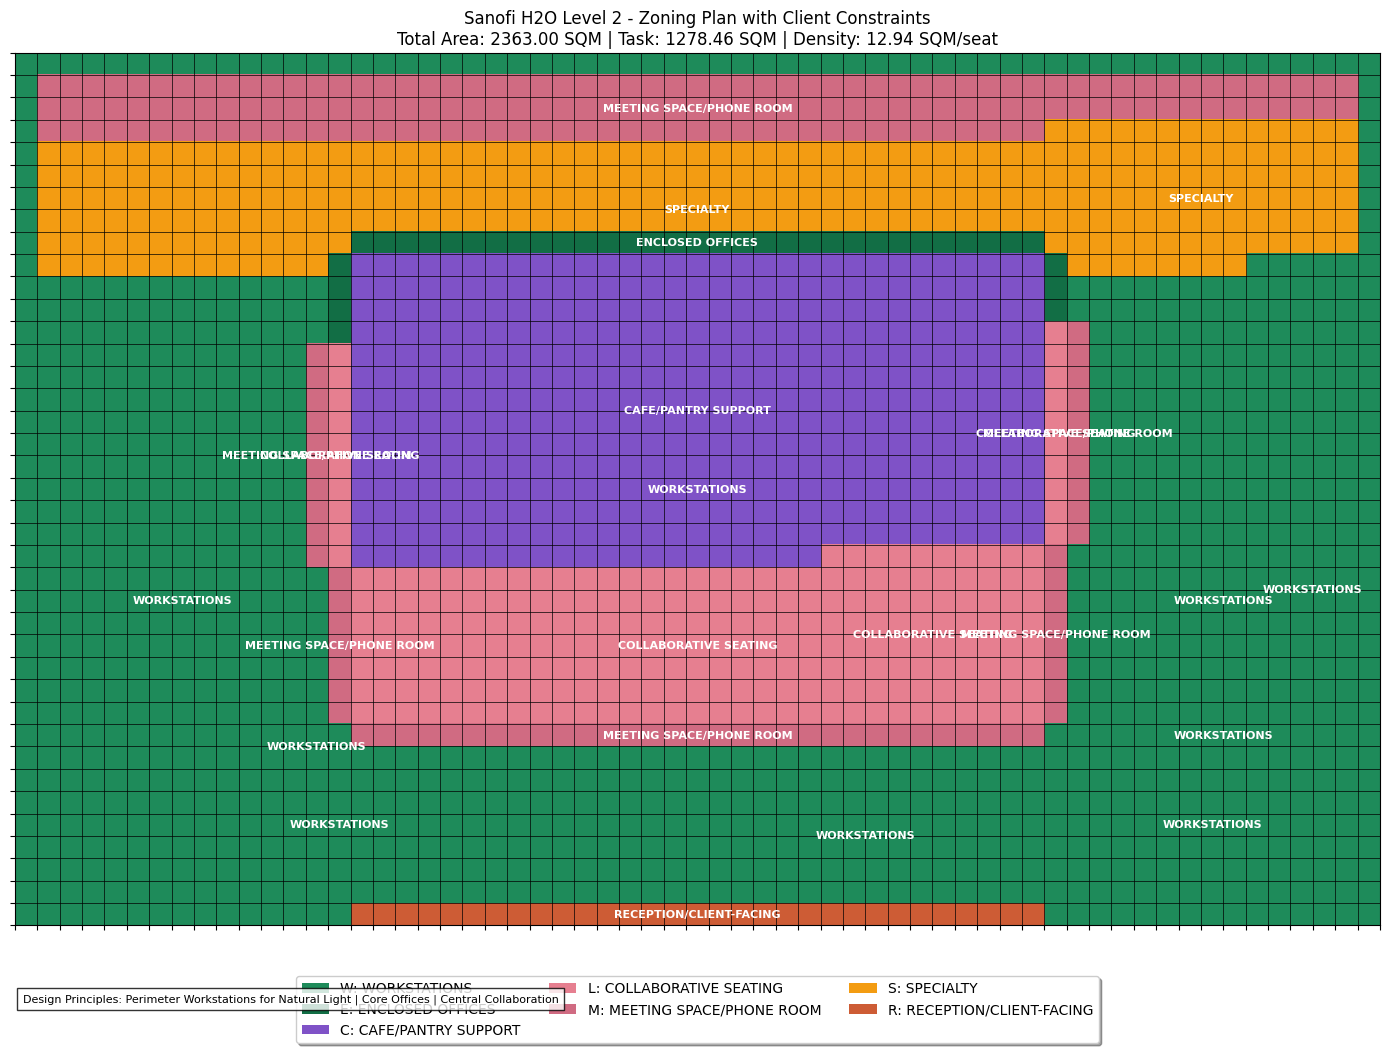


Final Compliance Score: 4/5 checks passed (80%)
Layout saved as: sanofi_h2o_level_2_zoning_plan.png


In [ ]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict

# Sanofi H2O building data (default values)
sanofi_data = {
    "Ground Floor": {"area_sqm": 1595, "anchor_pct": 9.00, "collaborator_pct": 0.41, "density": 16.17},
    "Level 1": {"area_sqm": 1181, "anchor_pct": 5.85, "collaborator_pct": 0.30, "density": 30.37},
    "Level 2": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 3": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 4": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 5": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 6": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 7": {"area_sqm": 2327, "anchor_pct": 11.53, "collaborator_pct": 0.59, "density": 23.59},
    "Level 8": {"area_sqm": 2281, "anchor_pct": 11.30, "collaborator_pct": 0.58, "density": 23.13}
}

# Default seat counts for Typical TF
typical_tf_seats = {
    "Individual Zone Work Desks (no partition)": 46,
    "Individual Zone Phone Booths (Single)": 3,
    "Individual Zone Phone Booths (Double)": 3,
    "Individual Zone Focus Rooms (1p)": 5,
    "Individual Zone Focus Rooms (2-3p)": 4,
    "Individual Zone Touchdown n Seats": 46,
    "Interactive Zone Work Desks (with partitions)": 36,
    "Interactive Zone Phone Booths (Single)": 3,
    "Interactive Zone Phone Booths (Double)": 3,
    "Interactive Zone Focus Rooms (1p)": 5,
    "Interactive Zone Focus Rooms (2-3p)": 4,
    "Interactive Zone Touchdown n Seats": 18
}

def calculate_hcf(a, b):
    while b:
        a, b = b, a % b
    return a

def calculate_grid_dimensions(total_area, zone_areas):
    # Start with a more rectangular grid that approximates real floor layouts
    # Aim for a ratio of 1.5:1 for width:height for more realistic floor plates
    ratio = 1.5
    rows = int(math.sqrt(total_area / ratio))
    cols = int(rows * ratio)

    # Adjust to ensure we have enough cells
    while rows * cols < total_area:
        cols += 1

    return rows, cols

def calculate_area_from_seats(seat_counts, density):
    total_seats = sum(seat_counts.values())
    task_area = total_seats * density
    return task_area, total_seats

def create_constraint_based_zoning(rows, cols, space_counts):
    """Create zoning based on architectural constraints from the client"""
    grid = [[None for _ in range(cols)] for _ in range(rows)]

    # Define perimeter area (external facing cells for natural light)
    perimeter_cells = []
    for r in range(rows):
        for c in range(cols):
            if r == 0 or r == rows-1 or c == 0 or c == cols-1:
                perimeter_cells.append((r, c))

    # Define central core area (25-30% in the middle)
    core_start_r = rows // 4
    core_end_r = rows - rows // 4
    core_start_c = cols // 4
    core_end_c = cols - cols // 4

    core_cells = []
    for r in range(core_start_r, core_end_r):
        for c in range(core_start_c, core_end_c):
            core_cells.append((r, c))

    # Define entry area (bottom side in this case - this can be changed as needed)
    entry_r = rows - 1  # Bottom row
    entry_start_c = cols // 4
    entry_end_c = cols - cols // 4

    entry_cells = []
    for c in range(entry_start_c, entry_end_c):
        entry_cells.append((entry_r, c))
        if (entry_r, c) in perimeter_cells:
            perimeter_cells.remove((entry_r, c))

    # Calculate remaining cells (not perimeter, core, or entry)
    remaining_cells = []
    for r in range(rows):
        for c in range(cols):
            if (r, c) not in perimeter_cells and (r, c) not in core_cells and (r, c) not in entry_cells:
                remaining_cells.append((r, c))

    # 1. Place Reception (R) at entry area
    r_count = space_counts['R']
    r_cells = entry_cells[:r_count]
    for r, c in r_cells:
        grid[r][c] = 'R'

    # 2. Place Workstations (W) in perimeter for natural light
    w_count = space_counts['W']
    w_cells = perimeter_cells[:w_count]
    for r, c in w_cells:
        grid[r][c] = 'W'

    # 3. Place Enclosed Offices (E) near core
    e_count = space_counts['E']
    # Identify cells adjacent to core but not in core
    office_candidates = []
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] is None:  # Cell is empty
                # Check if adjacent to core
                is_adjacent_to_core = False
                for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                    nr, nc = r + dr, c + dc
                    if (0 <= nr < rows and 0 <= nc < cols and
                        (nr, nc) in core_cells):
                        is_adjacent_to_core = True
                        break
                if is_adjacent_to_core:
                    office_candidates.append((r, c))

    e_cells = office_candidates[:e_count]
    for r, c in e_cells:
        grid[r][c] = 'E'

    # 4. Place Cafe/Support (C) in central core
    c_count = space_counts['C']
    c_cells = core_cells[:c_count]
    for r, c in c_cells:
        grid[r][c] = 'C'
    core_cells = core_cells[c_count:]  # Remove used cells

    # 5. Place Collaborative Seating (L) around cafe and between workstations
    l_count = space_counts['L']
    l_candidates = []

    # First prioritize cells adjacent to cafe
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] is None:  # Cell is empty
                # Check if adjacent to cafe
                is_adjacent_to_cafe = False
                for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                    nr, nc = r + dr, c + dc
                    if (0 <= nr < rows and 0 <= nc < cols and
                        grid[nr][nc] == 'C'):
                        is_adjacent_to_cafe = True
                        break
                if is_adjacent_to_cafe:
                    l_candidates.append((r, c))

    # Then add remaining core cells
    l_candidates.extend(core_cells)

    l_cells = l_candidates[:l_count]
    for r, c in l_cells:
        grid[r][c] = 'L'

    # 6. Place Meeting Spaces/Phone Rooms (M) near collaborative areas
    m_count = space_counts['M']
    m_candidates = []

    # Find cells adjacent to collaborative seating
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] is None:  # Cell is empty
                # Check if adjacent to collaborative seating
                is_adjacent_to_collab = False
                for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                    nr, nc = r + dr, c + dc
                    if (0 <= nr < rows and 0 <= nc < cols and
                        grid[nr][nc] == 'L'):
                        is_adjacent_to_collab = True
                        break
                if is_adjacent_to_collab:
                    m_candidates.append((r, c))

    # If not enough candidates, add other empty cells
    if len(m_candidates) < m_count:
        for r in range(rows):
            for c in range(cols):
                if grid[r][c] is None and (r, c) not in m_candidates:
                    m_candidates.append((r, c))
                    if len(m_candidates) >= m_count:
                        break
            if len(m_candidates) >= m_count:
                break

    m_cells = m_candidates[:m_count]
    for r, c in m_cells:
        grid[r][c] = 'M'

    # 7. Place Specialty (S) spaces in remaining strategic locations
    s_count = space_counts['S']
    s_candidates = []

    # Find remaining empty cells
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] is None:
                s_candidates.append((r, c))

    s_cells = s_candidates[:s_count]
    for r, c in s_cells:
        grid[r][c] = 'S'

    # Fill any remaining cells with workstations (W)
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] is None:
                grid[r][c] = 'W'
                space_counts['W'] += 1

    return grid

def optimize_blocks(grid):
    """Group similar cells into larger blocks where possible"""
    rows, cols = len(grid), len(grid[0])

    # Function to check if we can merge cells of the same type horizontally or vertically
    def can_merge(r1, c1, r2, c2):
        return 0 <= r1 < rows and 0 <= c1 < cols and 0 <= r2 < rows and 0 <= c2 < cols and grid[r1][c1] == grid[r2][c2]

    # Perform multiple passes to consolidate blocks
    for _ in range(3):  # Perform 3 optimization passes
        # Horizontal merging (try to create wider blocks)
        for r in range(rows):
            c = 0
            while c < cols - 1:
                if can_merge(r, c, r, c + 1):
                    # Look for longest sequence
                    end_c = c + 1
                    while end_c < cols - 1 and can_merge(r, c, r, end_c + 1):
                        end_c += 1

                    # Now try to expand vertically if possible
                    can_expand_up = r > 0
                    can_expand_down = r < rows - 1

                    # Check if we can expand up
                    if can_expand_up:
                        for check_c in range(c, end_c + 1):
                            if not can_merge(r, c, r - 1, check_c):
                                can_expand_up = False
                                break

                    # Check if we can expand down
                    if can_expand_down:
                        for check_c in range(c, end_c + 1):
                            if not can_merge(r, c, r + 1, check_c):
                                can_expand_down = False
                                break

                    # Expand if possible
                    if can_expand_up:
                        for check_c in range(c, end_c + 1):
                            grid[r - 1][check_c] = grid[r][c]

                    if can_expand_down:
                        for check_c in range(c, end_c + 1):
                            grid[r + 1][check_c] = grid[r][c]

                    c = end_c + 1
                else:
                    c += 1

        # Vertical merging (try to create taller blocks)
        for c in range(cols):
            r = 0
            while r < rows - 1:
                if can_merge(r, c, r + 1, c):
                    # Look for longest sequence
                    end_r = r + 1
                    while end_r < rows - 1 and can_merge(r, c, end_r + 1, c):
                        end_r += 1

                    # Now try to expand horizontally if possible
                    can_expand_left = c > 0
                    can_expand_right = c < cols - 1

                    # Check if we can expand left
                    if can_expand_left:
                        for check_r in range(r, end_r + 1):
                            if not can_merge(r, c, check_r, c - 1):
                                can_expand_left = False
                                break

                    # Check if we can expand right
                    if can_expand_right:
                        for check_r in range(r, end_r + 1):
                            if not can_merge(r, c, check_r, c + 1):
                                can_expand_right = False
                                break

                    # Expand if possible
                    if can_expand_left:
                        for check_r in range(r, end_r + 1):
                            grid[check_r][c - 1] = grid[r][c]

                    if can_expand_right:
                        for check_r in range(r, end_r + 1):
                            grid[check_r][c + 1] = grid[r][c]

                    r = end_r + 1
                else:
                    r += 1

    return grid

def visualize_zoning_grid(grid, category_names, floor_name, area_info=None):
    """Visualize the zoning grid with colors and textual annotations"""
    rows, cols = len(grid), len(grid[0])

    # Define colors for each zone type
    color_map = {
        'W': '#1E8B5A',  # Green for workstations
        'E': '#126E45',  # Dark green for enclosed offices
        'C': '#7F52C7',  # Purple for cafe/pantry
        'L': '#E67F90',  # Pink for collaborative seating
        'M': '#D06B82',  # Dark pink for meeting spaces
        'S': '#F39C12',  # Orange for specialty
        'R': '#CD5C35'   # Red/orange for reception
    }

    # Create a numeric grid for matplotlib
    numeric_grid = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            numeric_grid[r, c] = list(color_map.keys()).index(grid[r][c])

    # Create custom colormap
    colors = [color_map[k] for k in color_map.keys()]
    cmap = mcolors.ListedColormap(colors)

    # Plot the grid
    plt.figure(figsize=(14, 10))
    main_plot = plt.subplot(111)
    im = main_plot.imshow(numeric_grid, cmap=cmap)

    # Add grid lines
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
    plt.xticks(np.arange(-.5, cols, 1), [])
    plt.yticks(np.arange(-.5, rows, 1), [])

    # Add zone labels on the grid
    block_positions = {}  # To store center positions of blocks
    visited = set()

    for r in range(rows):
        for c in range(cols):
            if (r, c) not in visited:
                cell_type = grid[r][c]
                # Find the extent of this block
                block_r_start, block_c_start = r, c
                block_r_end, block_c_end = r, c

                # Scan horizontally
                c_scan = c
                while c_scan < cols and grid[r][c_scan] == cell_type:
                    block_c_end = c_scan
                    c_scan += 1

                # Scan vertically for each column in the horizontal range
                for c_scan in range(block_c_start, block_c_end + 1):
                    r_scan = r
                    while r_scan < rows and grid[r_scan][c_scan] == cell_type:
                        visited.add((r_scan, c_scan))
                        block_r_end = max(block_r_end, r_scan)
                        r_scan += 1

                # Calculate block center
                center_r = (block_r_start + block_r_end) / 2
                center_c = (block_c_start + block_c_end) / 2

                # Only add labels for larger blocks
                block_height = block_r_end - block_r_start + 1
                block_width = block_c_end - block_c_start + 1

                if block_height * block_width >= 4:  # Only label blocks of at least 4 cells
                    if cell_type not in block_positions:
                        block_positions[cell_type] = []
                    block_positions[cell_type].append((center_r, center_c, block_width, block_height))

    # Add labels at center of major blocks
    for cell_type, positions in block_positions.items():
        for center_r, center_c, width, height in positions:
            if width * height > 6:  # Only label larger blocks
                plt.text(center_c, center_r, category_names[cell_type],
                         ha='center', va='center', color='white',
                         fontsize=8, fontweight='bold')

    # Add color legend
    patches = []
    for i, (code, name) in enumerate(category_names.items()):
        if code in color_map:
            patches.append(plt.Rectangle((0,0), 1, 1, fc=color_map[code], label=f"{code}: {name}"))

    plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=3)

    # Add title with area information
    title = f'Sanofi H2O {floor_name} - Zoning Plan with Client Constraints'
    if area_info:
        title += f'\nTotal Area: {area_info["Total"]:.2f} SQM | Task: {area_info["Task"]:.2f} SQM | Density: {area_info["Density"]:.2f} SQM/seat'

    plt.title(title)
    plt.tight_layout()

    # Add annotations for design principles
    plt.figtext(0.02, 0.02, "Design Principles: Perimeter Workstations for Natural Light | Core Offices | Central Collaboration",
                wrap=True, fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

    # Save the figure
    plt.savefig(f'sanofi_h2o_{floor_name.replace(" ", "_").lower()}_zoning_plan.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_zone_compliance(grid, category_names):
    """Analyze how well the layout meets design constraints"""
    rows, cols = len(grid), len(grid[0])

    compliance_checks = {
        "Natural Light": {"pass": True, "details": []},
        "Core Offices": {"pass": True, "details": []},
        "Central Collaboration": {"pass": True, "details": []},
        "Reception Placement": {"pass": True, "details": []},
        "Block Formation": {"pass": True, "details": []}
    }

    # 1. Check workstations (W) for natural light (should be on perimeter)
    perimeter_cells = []
    for r in range(rows):
        for c in range(cols):
            if r == 0 or r == rows-1 or c == 0 or c == cols-1:
                perimeter_cells.append((r, c))

    w_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] == 'W']
    perimeter_w = sum(1 for cell in w_cells if cell in perimeter_cells)
    if perimeter_w / len(w_cells) < 0.65:  # At least 65% of workstations should have natural light
        compliance_checks["Natural Light"]["pass"] = False
        compliance_checks["Natural Light"]["details"].append(
            f"Only {perimeter_w/len(w_cells)*100:.1f}% of workstations have access to natural light (perimeter placement)."
        )
    else:
        compliance_checks["Natural Light"]["details"].append(
            f"{perimeter_w/len(w_cells)*100:.1f}% of workstations have access to natural light."
        )

    # 2. Check enclosed offices (E) for core placement
    core_start_r = rows // 4
    core_end_r = rows - rows // 4
    core_start_c = cols // 4
    core_end_c = cols - cols // 4

    core_cells = []
    for r in range(core_start_r, core_end_r):
        for c in range(core_start_c, core_end_c):
            core_cells.append((r, c))

    core_adjacent_cells = []
    for r, c in core_cells:
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nr, nc = r + dr, c + dc
            if (0 <= nr < rows and 0 <= nc < cols and
                (nr, nc) not in core_cells and (nr, nc) not in core_adjacent_cells):
                core_adjacent_cells.append((nr, nc))

    e_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] == 'E']
    core_e = sum(1 for cell in e_cells if cell in core_cells or cell in core_adjacent_cells)

    if core_e / len(e_cells) < 0.7:  # At least 70% of enclosed offices should be near core
        compliance_checks["Core Offices"]["pass"] = False
        compliance_checks["Core Offices"]["details"].append(
            f"Only {core_e/len(e_cells)*100:.1f}% of enclosed offices are placed near the core."
        )
    else:
        compliance_checks["Core Offices"]["details"].append(
            f"{core_e/len(e_cells)*100:.1f}% of enclosed offices are properly placed near the core."
        )

    # 3. Check collaborative spaces (C, L) for central placement
    collab_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] in ['C', 'L']]
    central_collab = sum(1 for cell in collab_cells if cell in core_cells)

    if central_collab / len(collab_cells) < 0.6:  # At least 60% of collaboration spaces should be central
        compliance_checks["Central Collaboration"]["pass"] = False
        compliance_checks["Central Collaboration"]["details"].append(
            f"Only {central_collab/len(collab_cells)*100:.1f}% of collaboration spaces are centrally located."
        )
    else:
        compliance_checks["Central Collaboration"]["details"].append(
            f"{central_collab/len(collab_cells)*100:.1f}% of collaboration spaces are centrally located."
        )

    # 4. Check reception (R) for entry placement (bottom row in our model)
    r_cells = [(r, c) for r in range(rows) for c in range(cols) if grid[r][c] == 'R']
    if not r_cells:
        compliance_checks["Reception Placement"]["pass"] = False
        compliance_checks["Reception Placement"]["details"].append(
            "No reception area was placed in the layout."
        )
    else:
        bottom_row_r = sum(1 for r, c in r_cells if r == rows - 1)
        if bottom_row_r / len(r_cells) < 0.8:  # At least 80% of reception should be at entry
            compliance_checks["Reception Placement"]["pass"] = False
            compliance_checks["Reception Placement"]["details"].append(
                f"Only {bottom_row_r/len(r_cells)*100:.1f}% of reception area is at the main entry."
            )
        else:
            compliance_checks["Reception Placement"]["details"].append(
                f"Reception is properly placed at the main entry point."
            )

    # 5. Check if we have created proper blocks (instead of scattered cells)
    visited = set()
    blocks_by_type = defaultdict(list)

    def find_block(r, c, zone_type):
        """Find the full block starting at (r,c) using flood fill"""
        if (r < 0 or r >= rows or c < 0 or c >= cols or
            (r, c) in visited or grid[r][c] != zone_type):
            return []

        visited.add((r, c))
        block = [(r, c)]

        # Check all 4 adjacent cells
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            block.extend(find_block(r + dr, c + dc, zone_type))

        return block

    # Find all blocks
    for r in range(rows):
        for c in range(cols):
            if (r, c) not in visited:
                zone_type = grid[r][c]
                block = find_block(r, c, zone_type)
                if block:
                    blocks_by_type[zone_type].append(block)

    # Count single cells (blocks of size 1) - we want to minimize these
    single_cells = sum(1 for blocks in blocks_by_type.values()
                       for block in blocks if len(block) == 1)

    # Count total cells
    total_cells = rows * cols

    if single_cells / total_cells > 0.1:  # No more than 10% of cells should be singles
        compliance_checks["Block Formation"]["pass"] = False
        compliance_checks["Block Formation"]["details"].append(
            f"{single_cells} isolated single cells found ({single_cells/total_cells*100:.1f}% of layout)."
        )
    else:
        compliance_checks["Block Formation"]["details"].append(
            f"Good block formation with only {single_cells} isolated cells ({single_cells/total_cells*100:.1f}% of layout)."
        )

    # Print analysis
    print("\nCompliance Analysis:")
    for check, result in compliance_checks.items():
        status = "✓ PASS" if result["pass"] else "✗ FAIL"
        print(f"{check}: {status}")
        for detail in result["details"]:
            print(f"  - {detail}")

    # Overall compliance score
    passed = sum(1 for check in compliance_checks.values() if check["pass"])
    print(f"\nOverall Compliance: {passed}/{len(compliance_checks)} checks passed ({passed/len(compliance_checks)*100:.0f}%)")

    return blocks_by_type, compliance_checks

# Main program
def main():
    print("Sanofi H2O Office Layout Planner - with Client Constraints")
    print("=" * 60)
    print("Available floors:", ", ".join(sanofi_data.keys()))
    floor = input("Enter the floor to plan (e.g., Ground Floor, Level 2): ").strip()
    if floor not in sanofi_data:
        print("Invalid floor. Using Level 2 as default.")
        floor = "Level 2"

    floor_data = sanofi_data.get(floor, sanofi_data["Level 2"])
    print(f"\nDefault Area Metrics for {floor}:")
    print(f"Total Usable Area: {floor_data['area_sqm']} SQM")
    print(f"Anchor Resident Area: {floor_data['area_sqm'] * (floor_data['anchor_pct'] / 100):.2f} SQM ({floor_data['anchor_pct']}%)")
    print(f"Collaborator Area: {floor_data['area_sqm'] * (floor_data['collaborator_pct'] / 100):.2f} SQM ({floor_data['collaborator_pct']}%)")
    print(f"Density: {floor_data['density']} SQM per seat")

    # Override with user input
    area_sqm = float(input(f"Enter Total Usable Area (SQM) [{floor_data['area_sqm']}]: ") or floor_data['area_sqm'])
    anchor_pct = float(input(f"Enter Anchor Resident % [{floor_data['anchor_pct']}]: ") or floor_data['anchor_pct'])
    collaborator_pct = float(input(f"Enter Collaborator % [{floor_data['collaborator_pct']}]: ") or floor_data['collaborator_pct'])
    density = float(input(f"Enter Density (SQM per seat) [{floor_data['density']}]: ") or floor_data['density'])

    print("\nEnter seat counts (default values for Typical TF in brackets):")#print("\nEnter seat counts (default values for Typical TF in brackets):")
    seat_counts = {}
    for desc, default in typical_tf_seats.items():
        count = int(input(f"{desc} [{default}]: ") or default)
        seat_counts[desc] = count
    task_area, total_seats = calculate_area_from_seats(seat_counts, density)
    print(f"Calculated Task Area: {task_area:.2f} SQM (for {total_seats} seats)")

    # Prompt for other areas
    areas = {}
    areas["Task"] = min(task_area, 1278.46)  # Cap for Typical TF
    for cat, default in {"Specialty": 250, "Support": 195.30, "Social": 91.32}.items():
        value = float(input(f"Enter {cat} area (SQM) [{default}]: ") or default)
        areas[cat] = value
    areas["Total"] = area_sqm
    areas["Density"] = density

    # Calculate grid dimensions
    zone_areas = [areas["Task"], areas["Specialty"], areas["Support"], areas["Social"]]
    rows, cols = calculate_grid_dimensions(area_sqm, zone_areas)
    print(f"Calculated Grid Dimensions: {rows}x{cols}")

    # Calculate cell counts for each zone
    sqm_per_cell = area_sqm / (rows * cols)

    print(f"Each grid cell represents approximately {sqm_per_cell:.2f} SQM")

    # Adjust space allocations based on design principles
    space_counts = {
        "W": round(0.45 * areas["Task"] / sqm_per_cell),  # Workstations (more on perimeter)
        "E": round(0.1 * areas["Task"] / sqm_per_cell),   # Enclosed Offices (Focus)
        "C": round(0.15 * areas["Total"] / sqm_per_cell), # Cafe/Pantry Support
        "L": round(0.2 * areas["Task"] / sqm_per_cell),   # Collaborative Seating
        "M": round(0.15 * areas["Task"] / sqm_per_cell),  # Meeting Space/Phone Room
        "S": round(areas["Specialty"] / sqm_per_cell),    # Specialty
        "R": round(0.1 * areas["Total"] / sqm_per_cell)   # Reception/Client-Facing
    }

    # Adjust counts to match grid size
    total_count = sum(space_counts.values())
    grid_size = rows * cols

    if total_count != grid_size:
        diff = grid_size - total_count

        # Distribute difference proportionally across zones
        adjustment = {}
        for zone, count in space_counts.items():
            adjustment[zone] = round(diff * (count / total_count))

        # Apply adjustments
        for zone, adj in adjustment.items():
            space_counts[zone] += adj

        # Check if we still need to adjust
        new_total = sum(space_counts.values())
        if new_total != grid_size:
            # Add or subtract remaining difference from largest zone
            largest_zone = max(space_counts.items(), key=lambda x: x[1])[0]
            space_counts[largest_zone] += (grid_size - new_total)

    # Define category names for visualization
    category_names = {
        "W": "WORKSTATIONS",
        "E": "ENCLOSED OFFICES",
        "C": "CAFE/PANTRY SUPPORT",
        "L": "COLLABORATIVE SEATING",
        "M": "MEETING SPACE/PHONE ROOM",
        "S": "SPECIALTY",
        "R": "RECEPTION/CLIENT-FACING"
    }

    # Print allocation counts
    print("\nZone Allocation Counts:")
    for zone, count in space_counts.items():
        print(f"{category_names[zone]}: {count} cells ({count * sqm_per_cell:.2f} SQM)")

    # Create zoning with constraint-based approach
    print("\nGenerating layout based on client constraints...")
    grid = create_constraint_based_zoning(rows, cols, space_counts)

    # Optimize blocks to create larger contiguous areas
    print("Optimizing layout to create larger contiguous blocks...")
    grid = optimize_blocks(grid)

    # Analyze the blocks and check constraint compliance
    blocks_by_type, compliance_checks = analyze_zone_compliance(grid, category_names)

    # Print text-based grid (for reference)
    print(f"\nZoning Plan for Sanofi H2O {floor} ({rows}x{cols} Grid):")
    for row in grid:
        print(" ".join(f"{cell}" for cell in row))

    # Print legend
    print("\nLegend:")
    for code, name in category_names.items():
        print(f"{code}: {name}")

    # Print area summary
    print(f"\nArea Summary:")
    print(f"Task Area: {areas['Task']:.2f} SQM")
    print(f"Specialty: {areas['Specialty']:.2f} SQM")
    print(f"Support: {areas['Support']:.2f} SQM")
    print(f"Social: {areas['Social']:.2f} SQM")
    print(f"Total: {areas['Total']} SQM")
    print(f"Density: {density} SQM per seat")

    # Visualize grid with colors and annotations
    visualize_zoning_grid(grid, category_names, floor, areas)

    # Final compliance summary
    passed = sum(1 for check in compliance_checks.values() if check["pass"])
    print(f"\nFinal Compliance Score: {passed}/{len(compliance_checks)} checks passed ({passed/len(compliance_checks)*100:.0f}%)")
    print("Layout saved as:", f'sanofi_h2o_{floor.replace(" ", "_").lower()}_zoning_plan.png')

if __name__ == "__main__":
    main()


IndentationError: unexpected indent (<ipython-input-13-7cee60db90c9>, line 2)

In [ ]:
import math
import random

# Sanofi H2O building data (default values)
sanofi_data = {
    "Ground Floor": {"area_sqm": 1595, "anchor_pct": 9.00, "collaborator_pct": 0.41, "density": 16.17},
    "Level 1": {"area_sqm": 1181, "anchor_pct": 5.85, "collaborator_pct": 0.30, "density": 30.37},
    "Level 2": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 3": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 4": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 5": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 6": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94},
    "Level 7": {"area_sqm": 2327, "anchor_pct": 11.53, "collaborator_pct": 0.59, "density": 23.59},
    "Level 8": {"area_sqm": 2281, "anchor_pct": 11.30, "collaborator_pct": 0.58, "density": 23.13}
}

# Default seat counts for Typical TF
typical_tf_seats = {
    "Individual Zone Work Desks (no partition)": 46,
    "Individual Zone Phone Booths (Single)": 3,
    "Individual Zone Phone Booths (Double)": 3,
    "Individual Zone Focus Rooms (1p)": 5,
    "Individual Zone Focus Rooms (2-3p)": 4,
    "Individual Zone Touchdown n Seats": 46,
    "Interactive Zone Work Desks (with partitions)": 36,
    "Interactive Zone Phone Booths (Single)": 3,
    "Interactive Zone Phone Booths (Double)": 3,
    "Interactive Zone Focus Rooms (1p)": 5,
    "Interactive Zone Focus Rooms (2-3p)": 4,
    "Interactive Zone Touchdown n Seats": 18
}

def calculate_hcf(a, b):
    while b:
        a, b = b, a % b
    return a

def calculate_grid_dimensions(total_area, zone_areas):
    # Approximate lengths based on zone proportions (e.g., 40% Workstations, 20% Collaboration, etc.)
    lengths = [int(total_area * 0.4), int(total_area * 0.2), int(total_area * 0.1), int(total_area * 0.1)]
    hcf = lengths[0]
    for i in range(1, len(lengths)):
        hcf = calculate_hcf(hcf, lengths[i])
    # Start with a square grid and adjust
    base = hcf
    rows = cols = int(math.sqrt(total_area / base))
    while rows * cols * base < total_area:
        if rows <= cols:
            rows += 1
        else:
            cols += 1
    return rows, cols

def calculate_area_from_seats(seat_counts, density):
    total_seats = sum(seat_counts.values())
    task_area = total_seats * density
    return task_area, total_seats

def calculate_default_areas(total_area, seat_counts, density):
    task_area, _ = calculate_area_from_seats(seat_counts, density)
    # Cap task_area if needed (e.g., 1278.46 for Typical TF)
    task_area = min(task_area, 1278.46)  # Adjust based on floor
    specialty = 250  # Default for Typical TF
    support = 195.30
    social = 91.32
    return {
        "Task": task_area,
        "Specialty": specialty,
        "Support": support,
        "Social": social,
        "Total": total_area
    }

def fill_zoning_grid(rows, cols, space_counts):
    total_cells = rows * cols
    if sum(space_counts.values()) != total_cells:
        print(f"Error: Sum of space categories must equal {total_cells}. Got {sum(space_counts.values())}.")
        return None

    grid = [[None] * cols for _ in range(rows)]

    # Define positions based on image layout (5x5 inspired)
    center_row = rows // 2
    center_col = cols // 2
    periphery = [(i, j) for i in range(rows) for j in range(cols) if i == 0 or i == rows-1 or j == 0 or j == cols-1]
    core = [(center_row, center_col)]
    entry = [(rows-1, center_col-1), (rows-1, center_col), (rows-1, center_col+1)]
    hub = [(i, j) for i in range(center_row-1, center_row+2) for j in range(center_col-1, center_col+2) if (i, j) not in core and (i, j) not in entry]
    quiet = [(i, j) for i in range(1, rows-1) for j in range(1, cols-1) if (i, j) not in hub and (i, j) not in core and (i, j) not in entry]

    # Fill regions
    for pos in entry:
        i, j = pos
        if space_counts.get('R', 0) > 0:
            grid[i][j] = 'R'
            space_counts['R'] -= 1

    for pos in core:
        i, j = pos
        if space_counts.get('C', 0) > 0:
            grid[i][j] = 'C'
            space_counts['C'] -= 1

    periphery_index = 0
    for pos in periphery:
        i, j = pos
        if grid[i][j] is None and space_counts.get('W', 0) > 0:
            grid[i][j] = 'W'
            space_counts['W'] -= 1
        periphery_index += 1

    for pos in hub:
        i, j = pos
        if grid[i][j] is None and space_counts.get('L', 0) > 0:
            grid[i][j] = 'L'
            space_counts['L'] -= 1

    for pos in quiet:
        i, j = pos
        if grid[i][j] is None and space_counts.get('M', 0) > 0:
            grid[i][j] = 'M'
            space_counts['M'] -= 1

    empty_positions = [(i, j) for i in range(rows) for j in range(cols) if grid[i][j] is None]
    random.shuffle(empty_positions)

    remaining_cats = []
    for cat, count in space_counts.items():
        remaining_cats.extend([cat] * count)
    random.shuffle(remaining_cats)

    for idx, (i, j) in enumerate(empty_positions):
        if idx < len(remaining_cats):
            grid[i][j] = remaining_cats[idx]

    return grid

# Main program
print("Available floors:", ", ".join(sanofi_data.keys()))
floor = input("Enter the floor to plan (e.g., Ground Floor, Level 2): ").strip()
if floor not in sanofi_data:
    print("Invalid floor. Using Level 2 as default.")
    floor = "Level 2"

floor_data = sanofi_data.get(floor, sanofi_data["Level 2"])
print(f"\nDefault Area Metrics for {floor}:")
print(f"Total Usable Area: {floor_data['area_sqm']} SQM")
print(f"Anchor Resident Area: {floor_data['area_sqm'] * (floor_data['anchor_pct'] / 100):.2f} SQM ({floor_data['anchor_pct']}%)")
print(f"Collaborator Area: {floor_data['area_sqm'] * (floor_data['collaborator_pct'] / 100):.2f} SQM ({floor_data['collaborator_pct']}%)")
print(f"Density: {floor_data['density']} SQM per seat")

# Override with user input
area_sqm = float(input(f"Enter Total Usable Area (SQM) [{floor_data['area_sqm']}]: ") or floor_data['area_sqm'])
anchor_pct = float(input(f"Enter Anchor Resident % [{floor_data['anchor_pct']}]: ") or floor_data['anchor_pct'])
collaborator_pct = float(input(f"Enter Collaborator % [{floor_data['collaborator_pct']}]: ") or floor_data['collaborator_pct'])
density = float(input(f"Enter Density (SQM per seat) [{floor_data['density']}]: ") or floor_data['density'])

print("\nEnter seat counts (default values for Typical TF in brackets):")
seat_counts = {}
for desc, default in typical_tf_seats.items():
    count = int(input(f"{desc} [{default}]: ") or default)
    seat_counts[desc] = count
task_area, total_seats = calculate_area_from_seats(seat_counts, density)
print(f"Calculated Task Area: {task_area:.2f} SQM (for {total_seats} seats)")

# Prompt for other areas
areas = {}
areas["Task"] = min(task_area, 1278.46)  # Cap for Typical TF
for cat, default in {"Specialty": 250, "Support": 195.30, "Social": 91.32}.items():
    value = float(input(f"Enter {cat} area (SQM) [{default}]: ") or default)
    areas[cat] = value
areas["Total"] = area_sqm

# Calculate grid dimensions
zone_areas = [areas["Task"], areas["Specialty"], areas["Support"], areas["Social"]]
rows, cols = calculate_grid_dimensions(area_sqm, zone_areas)
print(f"Calculated Grid Dimensions: {rows}x{cols}")

# Calculate cell counts
sqm_per_cell = area_sqm / (rows * cols)
space_counts = {
    "W": round(0.4 * areas["Task"] / sqm_per_cell),  # Workstations
    "E": round(0.1 * areas["Task"] / sqm_per_cell),  # Enclosed Offices (Focus)
    "C": round(0.2 * areas["Total"] / sqm_per_cell),  # Cafe/Pantry Support
    "L": round(0.2 * areas["Task"] / sqm_per_cell),  # Collaborative Seating
    "M": round(0.1 * areas["Task"] / sqm_per_cell),  # Meeting Space/Phone Room
    "S": round(areas["Specialty"] / sqm_per_cell),   # Specialty
    "R": round(0.1 * areas["Total"] / sqm_per_cell)  # Reception/Client-Facing
}
total_count = sum(space_counts.values())
if total_count != rows * cols:
    diff = rows * cols - total_count
    space_counts["W"] += diff  # Adjust Workstations

# Generate grid
grid = fill_zoning_grid(rows, cols, space_counts)

# Print results
print(f"\nZoning Plan for Sanofi H2O {floor} ({rows}x{cols} Grid):")
category_names = {
    "W": "WORKSTATIONS",
    "E": "ENCLOSED OFFICES",
    "C": "CAFE/PANTRY SUPPORT",
    "L": "COLLABORATIVE SEATING",
    "M": "MEETING SPACE/PHONE ROOM",
    "S": "SPECIALTY",
    "R": "RECEPTION/CLIENT-FACING COLLABORATIVE SPACE"
}
for row in grid:
    print(" ".join(f"{cell:<25}" for cell in row))

print("\nLegend:")
for code, name in category_names.items():
    print(f"{code}: {name}")
print(f"\nArea Summary:")
print(f"Task Area: {areas['Task']:.2f} SQM")
print(f"Specialty: {areas['Specialty']:.2f} SQM")
print(f"Support: {areas['Support']:.2f} SQM")
print(f"Social: {areas['Social']:.2f} SQM")
print(f"Total: {areas['Total']} SQM")
print(f"Density: {density} SQM per seat")

Available floors: Ground Floor, Level 1, Level 2, Level 3, Level 4, Level 5, Level 6, Level 7, Level 8
Enter the floor to plan (e.g., Ground Floor, Level 2): Level 2\
Invalid floor. Using Level 2 as default.

Default Area Metrics for Level 2:
Total Usable Area: 2363 SQM
Anchor Resident Area: 276.71 SQM (11.71%)
Collaborator Area: 14.18 SQM (0.6%)
Density: 12.94 SQM per seat
Enter Total Usable Area (SQM) [2363]: 2363
Enter Anchor Resident % [11.71]: 11.71
Enter Collaborator % [0.6]: .6
Enter Density (SQM per seat) [12.94]: 12.94

Enter seat counts (default values for Typical TF in brackets):
Individual Zone Work Desks (no partition) [46]: 46
Individual Zone Phone Booths (Single) [3]: 3
Individual Zone Phone Booths (Double) [3]: 3
Individual Zone Focus Rooms (1p) [5]: 5
Individual Zone Focus Rooms (2-3p) [4]: 4
Individual Zone Touchdown n Seats [46]: 46
Interactive Zone Work Desks (with partitions) [36]: 36
Interactive Zone Phone Booths (Single) [3]: 3
Interactive Zone Phone Booths (Doub

#Constraint-Based Programming

 minimize f(x)

 subject to gi(x) ≤ 0, i = 1,2,...,m

 hj(x) = 0, j =1,2,...,p

 Where:

 • x represents our design variables (spatial allocations, furnishings)

 • f(x) is our objective function (e.g., space utilization efficiency)

 • gi(x) represents inequality constraints (e.g., minimum space per per
son)

 • hj(x) represents equality constraints (e.g., fixed headcount require
ments)




# Grid Representation Architecture
 in company PS , system represents floor plans as specialized constraint grid where each
 cell maps to specific space type.

 we can use our grid constraint approch with some adaptations:

Space type encoding (replaces R/G/B color grid)

SPACE_TYPES = {

’W’: ’Workstation’,

 ’M’: ’Meeting Room’,

’C’: ’Collaboration Space’,

 ’P’: ’Pathway/Circulation’,

 ’S’: ’Support Space’,

 ’E’: ’Entry/Reception’,

 ’K’: ’Kitchen/Pantry’,

 ’L’: ’Lounge’,

 ’O’: ’Open Space’

}


# Space Type Encoding
  Core Constraint Categories

 ## Spatial Constraints

 • Building envelope constraints

 • Minimum space dimensions

 • Structural element avoidance (columns, load-bearing walls)

 • Core area reservations (elevators, stairs, restrooms)


 ##  Functional Constraints

 • Headcount requirements

 • Space type ratios (collaborative vs. focused work)

 • Adjacency requirements

 • Circulation flow requirements

 ##  Compliance Constraints

 • Accessibility requirements (ADA compliance)

 • Fire safety regulations

 • Building codes

 • Company design standards

 ## Experience Constraints

 • Natural light access

 • Acoustic considerations

 • Visual privacy

 • Spatial density

 ## Sustainability Constraints

 • Energy efficiency

 • Material selection

 • Water usage

 • Waste reduction




 ## Formulation

Constraint Representation

 For each grid cell (i,j), we define a variable Xi,j representing its space type,

 where:

 Xi,j ∈ {W,M,C,P,S,E,K,L,O}

 ## Objective Function

so multi-objective optimization approach balances competing factors:

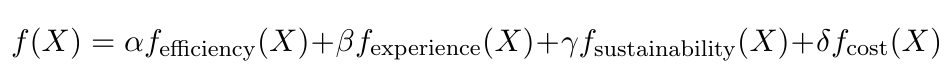


 Where α,β,γ,δ are weights that can be adjusted based on project pri
orities.


## Example constraint :

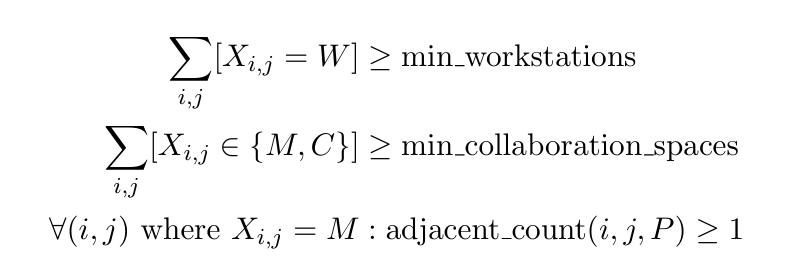

# Core Algorithms


## Constraint Propagation


## Simulated Annealing for Layout Optimization

## Pattern Recognition and Historical Learning

# system Architecture


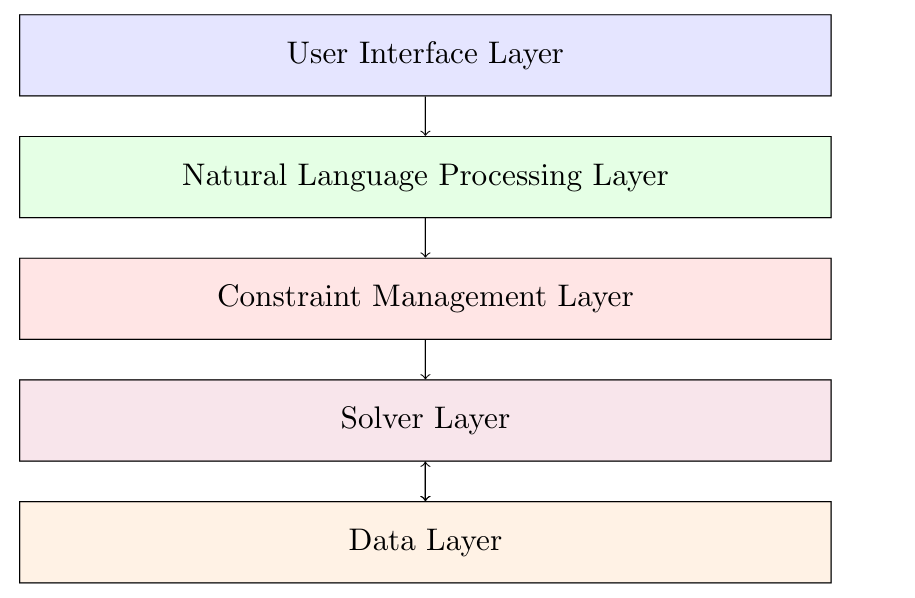

# If the Grid dimension are also specified (which is not the case for sanofi) then we can simply use our previous Multiple constraint methods

In [ ]:
import random

# Sanofi H2O building data (from Excel snippet)
sanofi_data = {
    "Ground Floor": {"area_sqm": 1595, "anchor_pct": 9.00, "collaborator_pct": 0.41, "density": 16.17, "seatcount": 1248, "headcount": 1980},
    "Level 1": {"area_sqm": 1181, "anchor_pct": 5.85, "collaborator_pct": 0.30, "density": 30.37, "seatcount": 64, "headcount": 220},
    "Level 2": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94, "seatcount": 1312, "headcount": 2200},
    "Level 3": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94, "seatcount": 1312, "headcount": 2200},
    "Level 4": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94, "seatcount": 1312, "headcount": 2200},
    "Level 5": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94, "seatcount": 1312, "headcount": 2200},
    "Level 6": {"area_sqm": 2363, "anchor_pct": 11.71, "collaborator_pct": 0.60, "density": 12.94, "seatcount": 1312, "headcount": 2200},
    "Level 7": {"area_sqm": 2327, "anchor_pct": 11.53, "collaborator_pct": 0.59, "density": 23.59, "seatcount": 64, "headcount": 220},
    "Level 8": {"area_sqm": 2281, "anchor_pct": 11.30, "collaborator_pct": 0.58, "density": 23.13, "seatcount": 64, "headcount": 220}
}

# Default seat counts for Typical TF (Levels 2–6)
typical_tf_seats = {
    "Individual Zone Work Desks (no partition)": 46,
    "Individual Zone Phone Booths (Single)": 3,
    "Individual Zone Phone Booths (Double)": 3,
    "Individual Zone Focus Rooms (1p)": 5,
    "Individual Zone Focus Rooms (2-3p)": 4,
    "Individual Zone Touchdown n Seats": 46,
    "Interactive Zone Work Desks (with partitions)": 36,
    "Interactive Zone Phone Booths (Single)": 3,
    "Interactive Zone Phone Booths (Double)": 3,
    "Interactive Zone Focus Rooms (1p)": 5,
    "Interactive Zone Focus Rooms (2-3p)": 4,
    "Interactive Zone Touchdown n Seats": 18
}

def calculate_area_from_seats(seat_counts, density):
    total_seats = sum(seat_counts.values())
    task_area = total_seats * density
    return task_area, total_seats

def calculate_default_areas(floor_data, seat_counts):
    area_sqm = floor_data["area_sqm"]
    density = floor_data["density"]
    task_area, total_seats = calculate_area_from_seats(seat_counts, density)
    # Cap task_area to 1278.46 SQM for Typical TF (Levels 2–6)
    typical_tf_floors = ["Level 2", "Level 3", "Level 4", "Level 5", "Level 6"]
    task_area = min(task_area, 1278.46) if floor in typical_tf_floors else task_area
    anchor_area = area_sqm * (floor_data["anchor_pct"] / 100)
    collaborator_area = area_sqm * (floor_data["collaborator_pct"] / 100)
    # Default areas from Excel (adjustable)
    specialty = 250 if area_sqm == 2363 else (1100 if area_sqm in [2327, 2281] else 450)
    support = 195.30 if area_sqm == 2363 else (191.46 if area_sqm == 2327 else 145.46)
    social = 91.32 if area_sqm == 2363 else 49.31
    return {
        "Task": task_area,
        "Specialty": specialty,
        "Support": support,
        "Social": social,
        "Total": area_sqm
    }

def calculate_cell_counts(areas, rows, cols):
    total_cells = rows * cols
    sqm_per_cell = areas["Total"] / total_cells
    counts = {
        "I": round(0.8 * areas["Task"] / sqm_per_cell),  # Individual Work
        "F": round(0.2 * areas["Task"] / sqm_per_cell),  # Focus
        "C": round((areas["Total"] - areas["Task"] - areas["Specialty"] - areas["Support"] - areas["Social"]) / sqm_per_cell),  # Collaboration
        "S": round(areas["Support"] / sqm_per_cell),
        "O": round(areas["Social"] / sqm_per_cell),
        "P": round(areas["Specialty"] / sqm_per_cell),
        "E": 1  # Minimal entry
    }
    # Adjust to match total_cells
    total_count = sum(counts.values())
    if total_count != total_cells:
        diff = total_cells - total_count
        counts["I"] += diff  # Adjust Workstations
    return counts

def fill_zoning_grid(rows, cols, space_counts, periphery_cats=None, core_cats=None, entry_cats=None):
    total_cells = rows * cols
    if sum(space_counts.values()) != total_cells:
        print(f"Error: Sum of space categories must equal {total_cells}. Got {sum(space_counts.values())}.")
        return None

    grid = [[None] * cols for _ in range(rows)]

    # Define positions
    periphery_positions = []
    for j in range(cols):
        periphery_positions.append((0, j))  # Top
    for i in range(1, rows):
        periphery_positions.append((i, cols - 1))  # Right
    for j in range(cols - 2, -1, -1):
        periphery_positions.append((rows - 1, j))  # Bottom
    for i in range(rows - 2, 0, -1):
        periphery_positions.append((i, 0))  # Left

    core_rows = max(1, rows // 3)
    core_cols = max(1, cols // 3)
    core_start_row = (rows - core_rows) // 2
    core_start_col = (cols - core_cols) // 2
    core_positions = [(i, j) for i in range(core_start_row, core_start_row + core_rows)
                      for j in range(core_start_col, core_start_col + core_cols)]

    entry_positions = [(0, 0), (0, 1), (1, 0), (1, 1)][:min(4, total_cells)]

    hub_positions = [(i, j) for i in range(1, rows - 1) for j in range(1, cols - 1)
                     if (i, j) not in core_positions]

    quiet_positions = [(i, j) for i in range(1, rows - 1) for j in range(1, cols - 1)
                       if (i, j) not in core_positions and (i, j) not in hub_positions]

    # Fill regions
    for pos in entry_positions:
        i, j = pos
        if entry_cats and space_counts.get('E', 0) > 0:
            grid[i][j] = 'E'
            space_counts['E'] -= 1

    for pos in core_positions:
        i, j = pos
        if grid[i][j] is None and core_cats and space_counts.get(core_cats[0], 0) > 0:
            grid[i][j] = core_cats[0]
            space_counts[core_cats[0]] -= 1

    periphery_index = 0
    periphery_cats = periphery_cats or []
    for pos in periphery_positions:
        i, j = pos
        if grid[i][j] is None:
            cat = periphery_cats[periphery_index % len(periphery_cats)] if periphery_cats else 'I'
            if space_counts.get(cat, 0) > 0:
                grid[i][j] = cat
                space_counts[cat] -= 1
            periphery_index += 1

    for pos in hub_positions:
        i, j = pos
        if grid[i][j] is None and space_counts.get('C', 0) > 0:
            grid[i][j] = 'C'
            space_counts['C'] -= 1

    for pos in quiet_positions:
        i, j = pos
        if grid[i][j] is None and space_counts.get('F', 0) > 0:
            grid[i][j] = 'F'
            space_counts['F'] -= 1

    empty_positions = [(i, j) for i in range(rows) for j in range(cols) if grid[i][j] is None]
    random.shuffle(empty_positions)

    remaining_cats = []
    for cat, count in space_counts.items():
        remaining_cats.extend([cat] * count)
    random.shuffle(remaining_cats)

    for idx, (i, j) in enumerate(empty_positions):
        if idx < len(remaining_cats):
            grid[i][j] = remaining_cats[idx]

    return grid

# Main program
print("Available floors:", ", ".join(sanofi_data.keys()))
floor = input("Enter the floor to plan (e.g., Ground Floor, Level 2): ").strip()
if floor not in sanofi_data:
    print("Invalid floor. Using Level 2 as default.")
    floor = "Level 2"

floor_data = sanofi_data[floor]
rows = int(input("Enter number of rows for the grid: "))
cols = int(input("Enter number of columns for the grid: "))
total_cells = rows * cols

# Display area metrics
area_sqm = floor_data["area_sqm"]
anchor_area = area_sqm * (floor_data["anchor_pct"] / 100)
collaborator_area = area_sqm * (floor_data["collaborator_pct"] / 100)
density = floor_data["density"]
print(f"\nArea Metrics for {floor}:")
print(f"Total Usable Area: {area_sqm} SQM")
print(f"Anchor Resident Area: {anchor_area:.2f} SQM ({floor_data['anchor_pct']}%)")
print(f"Collaborator Area: {collaborator_area:.2f} SQM ({floor_data['collaborator_pct']}%)")
print(f"Density: {density} SQM per seat")

# Prompt for seat counts
seat_counts = {}
print("\nEnter seat counts (default values for Typical TF in brackets):")
for desc, default in typical_tf_seats.items():
    code = desc.split()[0][0]  # Simplify to first letter for grid
    count = int(input(f"{desc} [{default}]: ") or default)
    seat_counts[desc] = count
task_area, total_seats = calculate_area_from_seats(seat_counts, density)
print(f"Calculated Task Area: {task_area:.2f} SQM (for {total_seats} seats)")

# Prompt for other areas (default from Excel)
default_areas = calculate_default_areas(floor_data, seat_counts)
areas = {}
for cat, default in {"Specialty": default_areas["Specialty"], "Support": default_areas["Support"], "Social": default_areas["Social"]}.items():
    value = float(input(f"Enter {cat} area (SQM) [{default}]: ") or default)
    areas[cat] = value
areas["Task"] = min(task_area, default_areas["Task"])  # Cap at Excel value
areas["Total"] = area_sqm

# Calculate cell counts
space_counts = calculate_cell_counts(areas, rows, cols)

# Define constraints
periphery_cats = ["I"]  # Individual Work on periphery
core_cats = ["S"]      # Support in core
entry_cats = ["E"]     # Entry zone

# Generate grid
grid = fill_zoning_grid(rows, cols, space_counts, periphery_cats, core_cats, entry_cats)

# Print results
print(f"\nZoning Plan for Sanofi H2O {floor} ({rows}x{cols} Grid):")
category_names = {
    "I": "Individual Work",
    "F": "Focus",
    "C": "Collaboration",
    "S": "Support",
    "O": "Social",
    "P": "Specialty",
    "E": "Entry"
}
for row in grid:
    print(" ".join(f"{cell:<2}" for cell in row))

print("\nLegend:")
for code, name in category_names.items():
    print(f"{code}: {name}")
print(f"\nArea Summary:")
print(f"Task Area: {areas['Task']:.2f} SQM")
print(f"Specialty: {areas['Specialty']:.2f} SQM")
print(f"Support: {areas['Support']:.2f} SQM")
print(f"Social: {areas['Social']:.2f} SQM")
print(f"Total: {areas['Total']} SQM")
print(f"Density: {density} SQM per seat")

Available floors: Ground Floor, Level 1, Level 2, Level 3, Level 4, Level 5, Level 6, Level 7, Level 8
Enter the floor to plan (e.g., Ground Floor, Level 2): Level 4
Enter number of rows for the grid: 10
Enter number of columns for the grid: 10

Area Metrics for Level 4:
Total Usable Area: 2363 SQM
Anchor Resident Area: 276.71 SQM (11.71%)
Collaborator Area: 14.18 SQM (0.6%)
Density: 12.94 SQM per seat

Enter seat counts (default values for Typical TF in brackets):
Individual Zone Work Desks (no partition) [46]: 46
Individual Zone Phone Booths (Single) [3]: 3
Individual Zone Phone Booths (Double) [3]: 3
Individual Zone Focus Rooms (1p) [5]: 5
Individual Zone Focus Rooms (2-3p) [4]: 4
Individual Zone Touchdown n Seats [46]: 46
Interactive Zone Work Desks (with partitions) [36]: 36
Interactive Zone Phone Booths (Single) [3]: 3
Interactive Zone Phone Booths (Double) [3]: 3
Interactive Zone Focus Rooms (1p) [5]: 5
Interactive Zone Focus Rooms (2-3p) [4]: 4
Interactive Zone Touchdown n Seat

In [ ]:
import random

# Sanofi H2O building data (from Excel, Scenario-1)
sanofi_data = {
    "Ground Floor": {
        "area_sqm": 1595,
        "categories": {
            "Task": 690.36,  # Individual + Interactive (Workstations, Focus, Touchdown)
            "Specialty": 450,
            "Support": 109.46,
            "Collaboration": 295.87,
            "Social": 49.31,
            "Entry": 0  # Assumed for client-facing/welcome
        }
    },
    "Level 1": {
        "area_sqm": 1181,
        "categories": {
            "Task": 272.21,
            "Specialty": 600,
            "Support": 172.68,
            "Collaboration": 116.66,
            "Social": 19.44,
            "Entry": 0
        }
    },
    "Level 2": {
        "area_sqm": 2363,
        "categories": {
            "Task": 1278.46,
            "Specialty": 250,
            "Support": 195.30,
            "Collaboration": 547.91,
            "Social": 91.32,
            "Entry": 0
        }
    },
    # Levels 3–6 same as Level 2
    "Level 3": {"area_sqm": 2363, "categories": {"Task": 1278.46, "Specialty": 250, "Support": 195.30, "Collaboration": 547.91, "Social": 91.32, "Entry": 0}},
    "Level 4": {"area_sqm": 2363, "categories": {"Task": 1278.46, "Specialty": 250, "Support": 195.30, "Collaboration": 547.91, "Social": 91.32, "Entry": 0}},
    "Level 5": {"area_sqm": 2363, "categories": {"Task": 1278.46, "Specialty": 250, "Support": 195.30, "Collaboration": 547.91, "Social": 91.32, "Entry": 0}},
    "Level 6": {"area_sqm": 2363, "categories": {"Task": 1278.46, "Specialty": 250, "Support": 195.30, "Collaboration": 547.91, "Social": 91.32, "Entry": 0}},
    "Level 7": {
        "area_sqm": 2327,
        "categories": {
            "Task": 690.36,
            "Specialty": 1100,
            "Support": 191.46,
            "Collaboration": 295.87,
            "Social": 49.31,
            "Entry": 0
        }
    },
    "Level 8": {
        "area_sqm": 2281,
        "categories": {
            "Task": 690.36,
            "Specialty": 1100,
            "Support": 145.46,
            "Collaboration": 295.87,
            "Social": 49.31,
            "Entry": 0
        }
    }
}

def calculate_default_counts(floor_data, rows, cols):
    total_cells = rows * cols
    area_sqm = floor_data["area_sqm"]
    sqm_per_cell = area_sqm / total_cells

    # Approximate Task as Workstations (80%) + Focus (20%)
    task_sqm = floor_data["categories"]["Task"]
    workstation_sqm = task_sqm * 0.8
    focus_sqm = task_sqm * 0.2

    # Convert SQM to cells
    counts = {
        "I": round(workstation_sqm / sqm_per_cell),  # Workstations
        "F": round(focus_sqm / sqm_per_cell),       # Focus Rooms/Phone Booths
        "C": round(floor_data["categories"]["Collaboration"] / sqm_per_cell),  # Collaboration
        "S": round(floor_data["categories"]["Support"] / sqm_per_cell),        # Support
        "O": round(floor_data["categories"]["Social"] / sqm_per_cell),         # Social
        "P": round(floor_data["categories"]["Specialty"] / sqm_per_cell),      # Specialty
        "E": round(floor_data["categories"]["Entry"] / sqm_per_cell)           # Entry
    }

    # Adjust counts to match total_cells
    total_count = sum(counts.values())
    if total_count != total_cells:
        # Scale proportionally
        factor = total_cells / total_count
        for key in counts:
            counts[key] = round(counts[key] * factor)
        # Fine-tune to exact total
        diff = total_cells - sum(counts.values())
        if diff > 0:
            counts["I"] += diff  # Add to workstations
        elif diff < 0:
            counts["I"] = max(0, counts["I"] + diff)  # Subtract from workstations

    return counts

def fill_zoning_grid(rows, cols, space_counts, periphery_cats=None, core_cats=None, entry_cats=None):
    total_cells = rows * cols
    if sum(space_counts.values()) != total_cells:
        print(f"Error: Sum of space categories must equal {total_cells}. Got {sum(space_counts.values())}.")
        return None

    # Initialize grid
    grid = [[None] * cols for _ in range(rows)]

    # Define positions
    # Periphery: Top, right, bottom, left edges
    periphery_positions = []
    for j in range(cols):
        periphery_positions.append((0, j))  # Top
    for i in range(1, rows):
        periphery_positions.append((i, cols - 1))  # Right
    for j in range(cols - 2, -1, -1):
        periphery_positions.append((rows - 1, j))  # Bottom
    for i in range(rows - 2, 0, -1):
        periphery_positions.append((i, 0))  # Left

    # Core: Center cells (approximate)
    core_rows = max(1, rows // 3)
    core_cols = max(1, cols // 3)
    core_start_row = (rows - core_rows) // 2
    core_start_col = (cols - core_cols) // 2
    core_positions = [(i, j) for i in range(core_start_row, core_start_row + core_rows)
                      for j in range(core_start_col, core_start_col + core_cols)]

    # Entry: Top-left corner
    entry_positions = [(0, 0), (0, 1), (1, 0), (1, 1)][:min(4, total_cells)]

    # Hub: Central but not core
    hub_positions = [(i, j) for i in range(1, rows - 1) for j in range(1, cols - 1)
                     if (i, j) not in core_positions]

    # Quiet zones: Non-periphery, non-entry, non-core
    quiet_positions = [(i, j) for i in range(1, rows - 1) for j in range(1, cols - 1)
                      if (i, j) not in core_positions and (i, j) not in hub_positions]

    # Fill entry positions
    for pos in entry_positions:
        i, j = pos
        if entry_cats and space_counts.get('E', 0) > 0:
            grid[i][j] = 'E'
            space_counts['E'] -= 1

    # Fill core positions (Support)
    for pos in core_positions:
        i, j = pos
        if grid[i][j] is not None:
            continue
        if core_cats and space_counts.get(core_cats[0], 0) > 0:
            grid[i][j] = core_cats[0]
            space_counts[core_cats[0]] -= 1

    # Fill periphery positions (Workstations)
    periphery_index = 0
    periphery_cats = periphery_cats or []
    for pos in periphery_positions:
        i, j = pos
        if grid[i][j] is not None:
            continue
        cat = periphery_cats[periphery_index % len(periphery_cats)] if periphery_cats else 'I'
        if space_counts.get(cat, 0) > 0:
            grid[i][j] = cat
            space_counts[cat] -= 1
        periphery_index += 1

    # Fill hub positions (Collaboration)
    for pos in hub_positions:
        i, j = pos
        if grid[i][j] is not None:
            continue
        if space_counts.get('C', 0) > 0:
            grid[i][j] = 'C'
            space_counts['C'] -= 1

    # Fill quiet zones (Focus)
    for pos in quiet_positions:
        i, j = pos
        if grid[i][j] is not None:
            continue
        if space_counts.get('F', 0) > 0:
            grid[i][j] = 'F'
            space_counts['F'] -= 1

    # Fill remaining with Social and Specialty
    empty_positions = [(i, j) for i in range(rows) for j in range(cols) if grid[i][j] is None]
    random.shuffle(empty_positions)

    remaining_cats = []
    for cat, count in space_counts.items():
        remaining_cats.extend([cat] * count)
    random.shuffle(remaining_cats)

    for idx, (i, j) in enumerate(empty_positions):
        if idx < len(remaining_cats):
            grid[i][j] = remaining_cats[idx]

    return grid

# Main program
print("Available floors:", ", ".join(sanofi_data.keys()))
floor = input("Enter the floor to plan (e.g., Ground Floor, Level 2): ").strip()
if floor not in sanofi_data:
    print("Invalid floor. Using Level 2 as default.")
    floor = "Level 2"

rows = int(input("Enter number of rows for the grid: "))
cols = int(input("Enter number of columns for the grid: "))
total_cells = rows * cols

# Get default counts from Sanofi data
default_counts = calculate_default_counts(sanofi_data[floor], rows, cols)

# Display defaults and ask for overrides
print("\nDefault space category counts (based on Sanofi data):")
category_names = {
    "I": "Workstation",
    "F": "Focus",
    "C": "Collaboration",
    "S": "Support",
    "O": "Social",
    "P": "Specialty",
    "E": "Entry"
}
for code, name in category_names.items():
    print(f"{name} ({code}): {default_counts.get(code, 0)} cells")

use_defaults = input("\nUse default counts? (y/n): ").strip().lower() == 'y'

if use_defaults:
    space_counts = default_counts
else:
    print("\nEnter custom cell counts for each category (must sum to", total_cells, "):")
    space_counts = {}
    for code, name in category_names.items():
        count = int(input(f"Number of {name} ({code}) cells: "))
        space_counts[code] = count

    # Validate total
    if sum(space_counts.values()) != total_cells:
        print("Error: Total cell counts do not match grid size. Adjusting Workstations.")
        space_counts["I"] += total_cells - sum(space_counts.values())

# Define constraints
periphery_cats = ["I"]  # Workstations on periphery
core_cats = ["S"]      # Support in core
entry_cats = ["E"]     # Entry zone

# Generate grid
grid = fill_zoning_grid(rows, cols, space_counts, periphery_cats, core_cats, entry_cats)

# Print grid
print(f"\nZoning Plan for Sanofi H2O {floor} ({rows}x{cols} Grid):")
for row in grid:
    print(" ".join(f"{cell:<2}" for cell in row))

# Print legend
print("\nLegend:")
for code, name in category_names.items():
    print(f"{code}: {name}")

Available floors: Ground Floor, Level 1, Level 2, Level 3, Level 4, Level 5, Level 6, Level 7, Level 8
Enter the floor to plan (e.g., Ground Floor, Level 2): Level 2
Enter number of rows for the grid: 5
Enter number of columns for the grid: 5

Default space category counts (based on Sanofi data):
Workstation (I): 10 cells
Focus (F): 3 cells
Collaboration (C): 6 cells
Support (S): 2 cells
Social (O): 1 cells
Specialty (P): 3 cells
Entry (E): 0 cells

Use default counts? (y/n): n

Enter custom cell counts for each category (must sum to 25 ):
Number of Workstation (I) cells: 5
Number of Focus (F) cells: 8
Number of Collaboration (C) cells: 3
Number of Support (S) cells: 4
Number of Social (O) cells: 1
Number of Specialty (P) cells: 2
Number of Entry (E) cells: 2

Zoning Plan for Sanofi H2O Level 2 (5x5 Grid):
E  E  I  I  I 
F  C  C  C  I 
F  S  S  P  I 
P  F  S  F  F 
O  S  F  F  F 

Legend:
I: Workstation
F: Focus
C: Collaboration
S: Support
O: Social
P: Specialty
E: Entry
